In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
plt.style.use('seaborn')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.width = 0

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf.flatten(),index=eVal.flatten())
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec

def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

"""
 FITTING
 THE
 MARCENKO–PASTUR PDF
"""
from scipy.optimize import minimize
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x: errPDFs(*x), .5 , args=(eVal,q,bWidth),
                    bounds=((1E-5,1-1E-5),)
                )
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax, var

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

### Import new CC data

In [127]:
result = pd.read_csv('~/Works/practicum_github_repo/Crypto-Data/ml_finance/daily_closing_300cc_yf.csv')

In [128]:
result

Date       BTC-USD      ETH-USD  USDT-USD     BNB-USD   ADA-USD  \
0     2014-09-17    457.334015          NaN       NaN         NaN       NaN   
1     2014-09-18    424.440002          NaN       NaN         NaN       NaN   
2     2014-09-19    394.795990          NaN       NaN         NaN       NaN   
3     2014-09-20    408.903992          NaN       NaN         NaN       NaN   
4     2014-09-21    398.821014          NaN       NaN         NaN       NaN   
...          ...           ...          ...       ...         ...       ...   
2485  2021-07-07  33855.328125  2315.161865  1.000708  327.522461  1.403118   
2486  2021-07-08  32877.371094  2120.026367  0.999900  310.427124  1.330146   
2487  2021-07-09  33798.011719  2146.692383  0.999639  316.484528  1.349474   
2488  2021-07-10  33520.519531  2111.403564  0.999980  316.140137  1.336085   
2489  2021-07-12  34372.757812  2148.219238  1.000154  323.013855  1.352602   

       XRP-USD  DOGE-USD  USDC-USD   DOT1-USD   HEX-USD   UNI3-USD  \
0     0.005399  0.000268       NaN        NaN       NaN        NaN   
1     0.005135  0.000298       NaN        NaN       NaN        NaN   
2     0.004942  0.000277       NaN        NaN       NaN        NaN   
3     0.004772  0.000292       NaN        NaN       NaN        NaN   
4     0.004570  0.000288       NaN        NaN       NaN        NaN   
...        ...       ...       ...        ...       ...        ...   
2485  0.651575  0.224126  1.000370  16.857790  0.084688  22.231146   
2486  0.623058  0.207597  0.999945  15.337749  0.082328  20.400131   
2487  0.636804  0.219864  0.999831        NaN  0.084257        NaN   
2488  0.625463  0.213920  1.000154        NaN  0.084081        NaN   
2489  0.637724  0.217238  1.000222  15.562801  0.086579  20.534269   

         BCH-USD     LTC-USD   SOL1-USD   LINK-USD  MATIC-USD  THETA-USD  \
0            NaN    5.058550        NaN        NaN        NaN        NaN   
1            NaN    4.685230        NaN        NaN        NaN        NaN   
2            NaN    4.327770        NaN        NaN        NaN        NaN   
3            NaN    4.286440        NaN        NaN        NaN        NaN   
4            NaN    4.245920        NaN        NaN        NaN        NaN   
...          ...         ...        ...        ...        ...        ...   
2485  508.864532  137.371216  36.591370  19.764128   1.128411   6.369528   
2486  490.991058  132.308502  33.203728  18.422050   1.043340   6.148720   
2487  504.062988  134.571594  33.264648  18.630384   1.051329   6.062796   
2488  497.499969  133.987289  31.788645  18.207788   1.029878   5.902700   
2489  499.628265  134.484772  32.221188  18.414804   1.046595   5.923392   

        ETC-USD   XLM-USD   ICP1-USD   VET-USD    FIL-USD   TRX-USD  \
0           NaN  0.003072        NaN       NaN        NaN       NaN   
1           NaN  0.003456        NaN       NaN        NaN       NaN   
2           NaN  0.003872        NaN       NaN        NaN       NaN   
3           NaN  0.003612        NaN       NaN        NaN       NaN   
4           NaN  0.003464        NaN       NaN        NaN       NaN   
...         ...       ...        ...       ...        ...       ...   
2485  52.810429  0.256940  45.358677  0.083428  56.416328  0.064295   
2486  49.624294  0.243421  40.273323  0.076189  53.885490  0.061122   
2487  50.118374  0.245802        NaN  0.076859  55.207897  0.062178   
2488  49.170948  0.245317        NaN  0.075949  54.264488  0.061378   
2489  49.939541  0.246428  39.738636  0.077860  55.170395  0.062051   

        AAVE-USD   EOS-USD     XMR-USD  LUNA1-USD   CRO-USD  ATOM1-USD  \
0            NaN       NaN    1.768350        NaN       NaN        NaN   
1            NaN       NaN    1.569280        NaN       NaN        NaN   
2            NaN       NaN    1.454370        NaN       NaN        NaN   
3            NaN       NaN    1.271210        NaN       NaN        NaN   
4            NaN       NaN    1.274150        NaN       NaN        NaN   
...         

In [129]:
result['Date'] = pd.to_datetime(result.Date)

In [130]:
result = result.set_index('Date').resample('D').asfreq().ffill()
# get data after Nov 2017
result = result.query('Date >= "2017-11-01"').dropna(axis=1)#.shape

In [131]:
# # result['date'] = pd.to_datetime(result['date'], format='%d/%m/%Y')
# # result = result.dropna()
# result.date.max() #.set_index('Date')
# result = result.set_index('date')
# # result = result[(result.index >= '2017-01-01') & ((result.index <= '2017-12-31'))]
# result = result.astype(float)

In [132]:
result

BTC-USD      ETH-USD  USDT-USD     BNB-USD   ADA-USD  \
Date                                                                    
2017-11-01   6767.310059   291.694000  1.001550    1.261540  0.022986   
2017-11-02   7078.500000   287.428986  1.001000    1.299630  0.021306   
2017-11-03   7207.759766   305.710999  1.006320    1.459220  0.022628   
2017-11-04   7379.950195   300.468994  1.002090    1.637200  0.022022   
2017-11-05   7407.410156   296.263000  0.998800    1.521660  0.020635   
...                  ...          ...       ...         ...       ...   
2021-07-08  32877.371094  2120.026367  0.999900  310.427124  1.330146   
2021-07-09  33798.011719  2146.692383  0.999639  316.484528  1.349474   
2021-07-10  33520.519531  2111.403564  0.999980  316.140137  1.336085   
2021-07-11  33520.519531  2111.403564  0.999980  316.140137  1.336085   
2021-07-12  34372.757812  2148.219238  1.000154  323.013855  1.352602   

             XRP-USD  DOGE-USD     BCH-USD     LTC-USD   LINK-USD    ETC-USD  \
Date                                                                           
2017-11-01  0.194124  0.001138  531.828003   53.180801   0.157611  10.263900   
2017-11-02  0.205861  0.001151  587.221985   54.737301   0.167427  10.239500   
2017-11-03  0.208133  0.001121  625.323975   56.181400   0.171798  12.663600   
2017-11-04  0.203750  0.001189  620.445007   55.037201   0.177603  11.892000   
2017-11-05  0.202055  0.001182  630.702026   54.746399   0.172059  13.243300   
...              ...       ...         ...         ...        ...        ...   
2021-07-08  0.623058  0.207597  490.991058  132.308502  18.422050  49.624294   
2021-07-09  0.636804  0.219864  504.062988  134.571594  18.630384  50.118374   
2021-07-10  0.625463  0.213920  497.499969  133.987289  18.207788  49.170948   
2021-07-11  0.625463  0.213920  497.499969  133.987289  18.207788  49.170948   
2021-07-12  0.637724  0.217238  499.628265  134.484772  18.414804  49.939541   

             XLM-USD   TRX-USD   EOS-USD     XMR-USD      MKR-USD   XTZ-USD  \
Date                                                                          
2017-11-01  0.027353  0.002510  1.045630   85.717003   248.315002  1.719730   
2017-11-02  0.027607  0.002312  1.115980   83.763603   248.315002  1.612340   
2017-11-03  0.027779  0.002227  1.211520   87.987000   248.315002  1.742890   
2017-11-04  0.027294  0.002128  1.120510   87.302696   248.315002  1.765360   
2017-11-05  0.026765  0.002219  1.094090   86.346901   248.315002  1.700080   
...              ...       ...       ...         ...          ...       ...   
2021-07-08  0.243421  0.061122  3.607471  205.441284  2661.630127  2.699327   
2021-07-09  0.245802  0.062178  4.212674  212.746994  2701.398438  2.749785   
2021-07-10  0.245317  0.061378  3.972061  209.556885  2667.518311  2.785909   
2021-07-11  0.245317  0.061378  3.972061  209.556885  2667.518311  2.785909   
2021-07-12  0.246428  0.062051  4.100923  212.161179  2684.976074  2.862109   

              NEO-USD  MIOTA-USD     DCR-USD  WAVES-USD     ZEC-USD  \
Date                                                                  
2017-11-01  26.862801   0.363920   26.886499   2.893800  222.412994   
2017-11-02  24.502701   0.366056   24.808201   3.186430  218.162003   
2017-11-03  26.820400   0.393126   27.607401   3.682680  232.632004   
2017-11-04  26.487801   0.368643   28.928600   3.622760  230.391998   
2017-11-05  26.380501   0.350084   29.038000   3.453890  225.354996   
...               ...        ...         ...        ...         ...   
2021-07-08  34.068920   0.816394  121.464493  14.866121  109.429771   
2021-07-09  34.712200   0.829389  131.646805  14.996265  110.932426   
2021-07-10  34.108524   0.792972  133.678253  14.184655  108.152512   
2021-07-11  34.108524   0.792972  133.678253  14.184655  108.152512   
2021-07-12  34.444180   0.841114  134.409943  14.290233  111.145500   

              DASH-USD  MANA-USD   ENJ-USD   XEM-USD   BAT-USD     BTG-USD

In [133]:
# remove any stable/fiat coins
result = result.loc[:, ~result.columns.isin(['USDT-USD', 'PAX-USD', 'TUSD-USD', 'USDC-USD', 'EURS-USD', 'SAI-USD'])]

In [135]:
result.mean()

BTC-USD      14041.474813
ETH-USD        583.167846
BNB-USD         57.135346
ADA-USD          0.266278
XRP-USD          0.466293
DOGE-USD         0.028570
BCH-USD        544.319020
LTC-USD         97.409443
LINK-USD         6.544799
ETC-USD         13.693917
XLM-USD          0.185739
TRX-USD          0.033788
EOS-USD          4.926475
XMR-USD        132.149940
MKR-USD        797.933408
XTZ-USD          2.350741
NEO-USD         29.137104
MIOTA-USD        0.753474
DCR-USD         49.258994
WAVES-USD        4.589106
ZEC-USD        131.291868
DASH-USD       201.886196
MANA-USD         0.131007
ENJ-USD          0.246046
XEM-USD          0.182063
BAT-USD          0.320961
BTG-USD         41.290476
BNT-USD          2.007909
ZEN-USD         21.632720
XWC-USD          0.251940
ZRX-USD          0.594890
QTUM-USD         7.443596
NANO-USD         3.027662
SC-USD           0.008479
ICX-USD          1.121827
DGB-USD          0.026778
OMG-USD          4.608384
XVG-USD          0.019735
SAND-USD    

In [136]:
sfilter = (result.mean() > 5)
col_list = sfilter[sfilter == True].index

In [137]:
result = result[col_list]

In [138]:
returns = result.pct_change().iloc[1:, :].copy()
# returns.dropna(axis = 1, thresh=len(returns.index)/2, inplace=True) # Drop stocks with over half the data missing
# returns.dropna(axis = 0, thresh=len(returns.columns), inplace=True) # Drop days without data for all stocks

In [139]:
returns

BTC-USD   ETH-USD   BNB-USD   BCH-USD   LTC-USD  LINK-USD  \
Date                                                                     
2017-11-02  0.045984 -0.014622  0.030193  0.104158  0.029268  0.062280   
2017-11-03  0.018261  0.063605  0.122796  0.064885  0.026382  0.026107   
2017-11-04  0.023890 -0.017147  0.121969 -0.007802 -0.020366  0.033790   
2017-11-05  0.003721 -0.013998 -0.070572  0.016532 -0.005284 -0.031216   
2017-11-06 -0.051928  0.008874  0.031630 -0.044481  0.007805 -0.026752   
...              ...       ...       ...       ...       ...       ...   
2021-07-08 -0.028886 -0.084286 -0.052196 -0.035124 -0.036854 -0.067905   
2021-07-09  0.028002  0.012578  0.019513  0.026624  0.017105  0.011309   
2021-07-10 -0.008210 -0.016439 -0.001088 -0.013020 -0.004342 -0.022683   
2021-07-11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-07-12  0.025424  0.017437  0.021743  0.004278  0.003713  0.011370   

             ETC-USD   XMR-USD   MKR-USD   NEO-USD   DCR-USD   ZEC-USD  \
Date                                                                     
2017-11-02 -0.002377 -0.022789  0.000000 -0.087858 -0.077299 -0.019113   
2017-11-03  0.236740  0.050420  0.000000  0.094590  0.112834  0.066327   
2017-11-04 -0.060931 -0.007777  0.000000 -0.012401  0.047857 -0.009629   
2017-11-05  0.113631 -0.010948  0.000000 -0.004051  0.003782 -0.021863   
2017-11-06  0.082260  0.191890  0.000000 -0.002453 -0.008334  0.014821   
...              ...       ...       ...       ...       ...       ...   
2021-07-08 -0.060332 -0.043794 -0.068096 -0.077856 -0.111937 -0.073688   
2021-07-09  0.009956  0.035561  0.014941  0.018882  0.083830  0.013732   
2021-07-10 -0.018904 -0.014995 -0.012542 -0.017391  0.015431 -0.025060   
2021-07-11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-07-12  0.015631  0.012428  0.006545  0.009841  0.005474  0.027674   

            DASH-USD   BTG-USD   ZEN-USD  QTUM-USD   GNO-USD   REP-USD  \
Date                                                                     
2017-11-02 -0.023037 -0.119920 -0.001500 -0.012846 -0.122999 -0.045585   
2017-11-03  0.050071  0.033402  0.396156  0.059887  0.023866  0.101847   
2017-11-04 -0.014035  0.078974 -0.135917 -0.032645  0.025223 -0.023025   
2017-11-05 -0.005512  0.165913  0.059325  0.008113  0.016308 -0.046212   
2017-11-06  0.009196 -0.102504 -0.016689  0.031066 -0.044118  0.016578   
...              ...       ...       ...       ...       ...       ...   
2021-07-08 -0.059181 -0.039154 -0.068470 -0.078834 -0.021773 -0.128596   
2021-07-09  0.014954  0.001345  0.016102  0.040916  0.010303 -0.017776   
2021-07-10 -0.001265 -0.034335 -0.035274 -0.019337  0.000924 -0.019568   
2021-07-11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-07-12  0.004371  0.014011  0.036607  0.013106  0.002210  0.035939   

             MCO-USD   MLN-USD   PPT-USD   GAS-USD   DGD-USD  VERI-USD  \
Date                                                                     
2017-11-02 -0.033419 -0.072694 -0.107288 -0.034494  0.052443  0.060557   
2017-11-03  0.094198  0.113742  0.126643  0.142636  0.130465  0.066239   
2017-11-04 -0.048542 -0.005566  0.030505 -0.017337 -0.002959  0.000246   
2017-11-05 -0.028954 -0.036648  0.001470 -0.020052 -0.061305  0.169605   
2017-11-06  0.061594 -0.020952  0.080773  0.027630 -0.029921 -0.150151   
...              ...       ...       ...       ...       ...       ...   
2021-07-08 -0.008432 -0.090606 -0.049306 -0.091925 -0.082805  0.149871   
2021-07-09 -0.013680  0.072959  0.053758 -0.008735  0.013384  0.000000   
2021-07-10 -0.001606  0.043936  0.001075 -0.018042 -0.037635  0.000000   
2021-07-11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-07-12  0.019673 -0.030875  0.003259  0.050839  0.032752 -0.069150   

            GBYTE-USD   FCT-USD  BLOCK-USD  
Date                                        
2017-11-02  -0.030645 -0.074775   0.001575  
2017-11-03   0.042815  0.2

In [140]:
# n = 120  #chunk row size
# list_df = [returns[i:i+n] for i in range(0,returns.shape[0],n)]

# [i.shape for i in list_df]


size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-90) if i < len(returns)-90]

[l_d.shape for l_d in list_of_dfs]

[(120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (120, 27),
 (119, 27)]

In [141]:
training_period = 30
in_sample = returns.iloc[:(returns.shape[0]-training_period), :].copy()

In [142]:
tickers = returns.columns

In [143]:
pd.set_option('use_inf_as_na', True)
in_sample_log_returns = np.log(1+in_sample)
# log_returns.dropna(0, inplace= True)
# log_returns.dropna(1, inplace= True)

In [148]:
# Shapiro-Wilk Test For Gausiannity 
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
# data = 5 * randn(100) + 50
# normality test
for i in range(len(in_sample_log_returns.columns)):
    stat, p = shapiro(in_sample_log_returns.iloc[:, i].values)
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print(i)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        pass
#         print('Sample does not look Gaussian (reject H0)')

In [149]:
# Shapiro-Wilk Test For Gausiannity 
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
# seed the random number generator
seed(1)
# generate univariate observations
# data = 5 * randn(100) + 50
# normality test
for i in range(len(in_sample_log_returns.columns)):
    stat, p = normaltest(in_sample_log_returns.iloc[:, i].values)
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print(i)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        pass
#         print('Sample does not look Gaussian (reject H0)')

In [150]:
# We will need the standard deviations later:
variances = np.diag(in_sample_log_returns.cov().values)
standard_deviations = np.sqrt(variances) 

In [151]:
corr_mat = in_sample_log_returns.interpolate().corr('spearman')

In [152]:
"""
Start with CCs correlation matrix 
"""
eVal0,eVec0=getPCA(corr_mat)

In [153]:
q = returns.shape[0]/corr_mat.shape[0]

In [154]:
# get bulk of Evalue and Variance
eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
# get nFacts
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

In [155]:
nFacts0

1

In [156]:
var0

0.99999

In [157]:
eMax0

1.3029493234421878

In [158]:
D, S = np.linalg.eigh(corr_mat)

print(D[D > eMax0])

[14.62322705]


In [159]:
len(D)

27

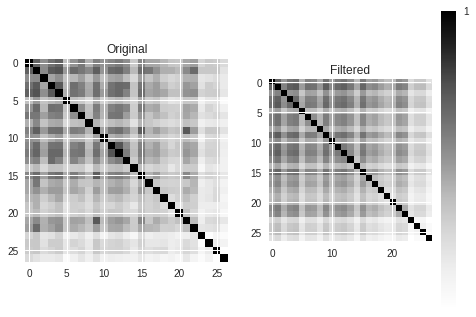

In [160]:
# Filter the eigenvalues out
D[D <= eMax0] = 0

# Reconstruct the matrix
temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))

# Set the diagonal entries to 0
np.fill_diagonal(temp, 1)
filtered_matrix = temp

f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(filtered_matrix)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [161]:
nFacts0

1

In [162]:
"""
 SNIPPET 2.5 DENOISING
 BY
 CONSTANT RESIDUAL EIGENVALUE
"""
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

# get denoised correlation matrix
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [163]:
eVal2,eVec2=getPCA(filtered_matrix)

In [164]:
findMaxEval(np.diag(eVec1), q, bWidth=.01)

(1.3029493234421878, 0.99999)

In [165]:
findMaxEval(np.diag(eVec2), q, bWidth=.01)

(1.3029493234421878, 0.99999)

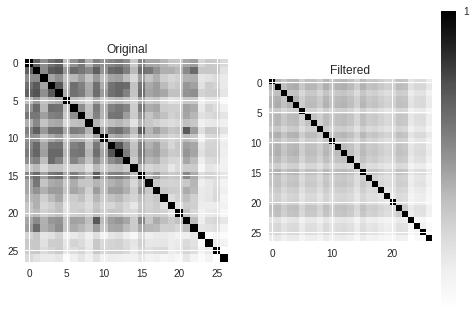

In [166]:
f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(corr1)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [32]:
in_sample

BTC       ETH       XRP       BCH       BSV       LTC  \
date                                                                     
2019-01-02  0.025989  0.101051  0.028708  0.042342  0.029737  0.045341   
2019-01-03 -0.027050 -0.038117 -0.040025 -0.056917 -0.065767 -0.041879   
2019-01-04  0.005468  0.036476 -0.009652 -0.004011 -0.011169  0.011552   
2019-01-05 -0.003248  0.006857 -0.004126 -0.006196  0.009926  0.078395   
2019-01-06  0.060189  0.013557  0.036929  0.040150  0.021012  0.124785   
2019-01-07 -0.012604 -0.038352 -0.010988 -0.033565 -0.017703 -0.037913   
2019-01-08  0.001391 -0.008833  0.002657  0.004155 -0.013517  0.044168   
2019-01-09  0.001104  0.002926  0.015261 -0.011303 -0.006166 -0.012411   
2019-01-10 -0.088316 -0.147016 -0.103098 -0.156859 -0.127757 -0.131316   
2019-01-11  0.002297 -0.008396  0.000758 -0.024450 -0.011723 -0.045468   
2019-01-12 -0.007070 -0.012387 -0.012328  0.020582  0.103559  0.001547   
2019-01-13 -0.029593 -0.072001 -0.033263 -0.059756 -0.064734 -0.063311   
2019-01-14  0.043091  0.104106  0.050031  0.060388  0.037836  0.066930   
2019-01-15 -0.020337 -0.054544 -0.019735 -0.041051 -0.036456 -0.026267   
2019-01-16  0.006701  0.012456  0.007708  0.005370  0.009814  0.009838   
2019-01-17  0.006443  0.001538 -0.001056  0.014554 -0.001918  0.002200   
2019-01-18 -0.005633 -0.022062 -0.015412 -0.019763 -0.026778 -0.018188   
2019-01-19  0.019337  0.029006  0.020735  0.013545  0.020669  0.039604   
2019-01-20 -0.034212 -0.040556 -0.029680 -0.048464 -0.028247 -0.042089   
2019-01-21 -0.006937 -0.019335 -0.001205 -0.008556 -0.004380  0.000962   
2019-01-22  0.007984  0.013571 -0.004049  0.045673  0.012265  0.015059   
2019-01-23 -0.005399 -0.010947 -0.009387  0.030209 -0.005136  0.010101   
2019-01-24  0.004393 -0.000766  0.003495 -0.022068 -0.013503  0.024375   
2019-01-25 -0.000305 -0.008350 -0.001363 -0.007960  0.002952  0.006101   
2019-01-26  0.000747  0.000945 -0.009238 -0.009582 -0.010302  0.005155   
2019-01-27 -0.005133 -0.026440 -0.015262 -0.033349 -0.028931 -0.016893   
2019-01-28 -0.031674 -0.060136 -0.047105 -0.084622 -0.095225 -0.042651   
2019-01-29 -0.006434 -0.009288 -0.017991 -0.012533 -0.022311 -0.003205   
2019-01-30  0.011038  0.031345  0.106725  0.065622  0.044696  0.026688   
2019-01-31 -0.008144 -0.016987 -0.032531 -0.030157 -0.036155 -0.008769   
2019-02-01  0.008722  0.005137 -0.004899  0.015243  0.005783  0.037283   
2019-02-02  0.009493  0.026206  0.007763  0.044870  0.021756  0.047518   
2019-02-03 -0.016203 -0.026623 -0.027532 -0.024304 -0.030875 -0.027624   
2019-02-04 -0.001403  0.003070 -0.007124  0.002440 -0.011299  0.020036   
2019-02-05  0.002084 -0.003524 -0.003195 -0.011837 -0.032698  0.004398   
2019-02-06 -0.015172 -0.023455 -0.028445 -0.020219  0.031999 -0.038821   
2019-02-07 -0.004189 -0.003622  0.003065 -0.001561 -0.006201  0.008807   
2019-02-08  0.078633  0.140903  0.068806  0.136431  0.077440  0.308248   
2019-02-09  0.001205  0.001341 -0.001280 -0.016965 -0.018563  0.030603   
2019-02-10  0.005173  0.045047 -0.004417 -0.008162  0.007868  0.045546   
2019-02-11 -0.011316 -0.028123 -0.023129 -0.039815 -0.024471 -0.077941   
2019-02-12  0.001398  0.010470  0.008089  0.007673  0.008002  0.017369   
2019-02-13 -0.005874 -0.000163 -0.002969 -0.002430 -0.014504 -0.043934   
2019-02-14 -0.004182 -0.009466 -0.007805 -0.012180 -0.028660 -0.008571   
2019-02-15  0.001087  0.005849 -0.000497  0.002548 -0.004785  0.025456   
2019-02-16  0.002480  0.009500 -0.000186  0.003280 -0.001763  0.020843   
2019-02-17  0.012136  0.083888  0.005525  0.019042  0.009311  0.007800   
2019-02-18  0.065836  0.093563  0.059986  0.158152  0.076030  0.093558   
2019-02-19  0.008014 -0.005133  0.006841 -0.007686 -0.008278 -0.003747   
2019-02-20  0.013359  0.028896  0.028144  0.033147  0.006111  0.082115   
2019-02-21 -0.011426 -0.022869 -0.034814 -0.034583 -0.031259 -0.050975   
2019-02-22  0.013002  0.020256  0.001908  0.015252  0.008717  0.013428   
2019-02-23  0.034203 

## After taking out tether portfolio much more reasonable here

/home/harshal/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


           Investment Weight
BTC-USD             0.823337
ETH-USD             0.183695
DCR-USD             0.150434
XMR-USD             0.126037
GBYTE-USD           0.064894


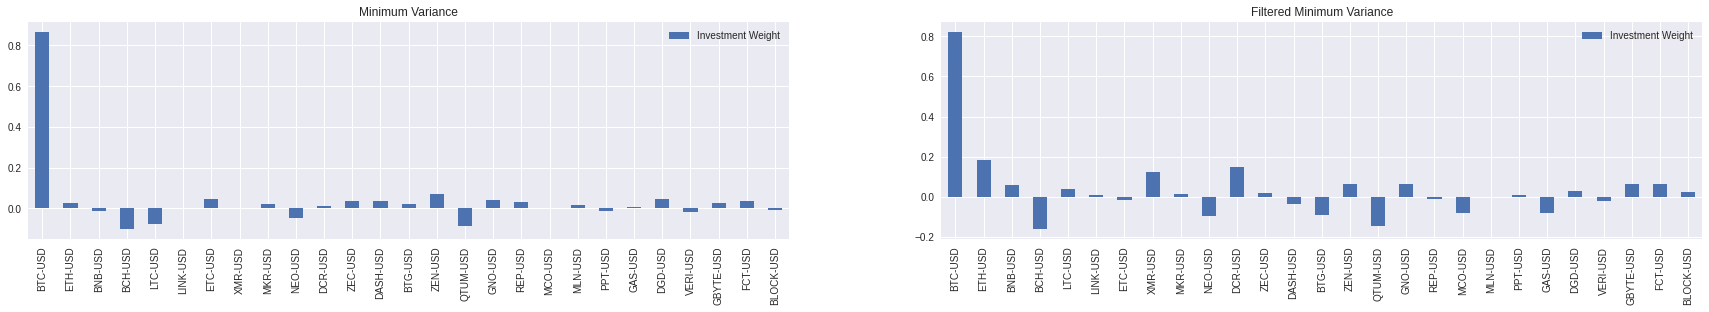

In [167]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(30,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

## Interesting as the MVR portfolio doesn't offer much better returns here, possibly because of 2017 inflation?

Text(0.5, 1.0, 'Filtered (Red) vs. Normal (Black)')

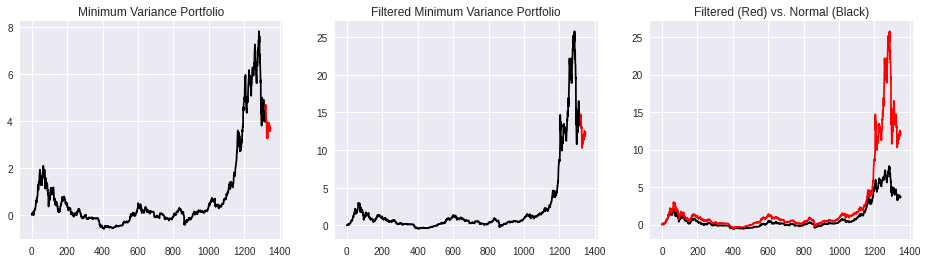

In [168]:
def get_cumulative_returns_over_time(sample, weights):
    # Ignoring short sales
    weights[weights <= 0 ] = 0 
    weights = weights / weights.sum()
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values

f = plt.figure(figsize=(16,4))

ax = plt.subplot(131)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(132)
ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
plt.title("Filtered Minimum Variance Portfolio")

ax = plt.subplot(133)
ax.plot(cumulative_returns, 'black')
ax.plot(cumulative_returns_filt, 'r')
plt.title("Filtered (Red) vs. Normal (Black)")

In [169]:
print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

           Investment Weight
BTC-USD             0.823337
ETH-USD             0.183695
DCR-USD             0.150434
XMR-USD             0.126037
GBYTE-USD           0.064894


### Sliding window Min Var Portfolios

In [170]:
def create_filtered_portfolios(returns, test_period):

    # test_period = 30
    in_sample = returns.iloc[:(returns.shape[0]-test_period), :].copy()
    in_sample_log_returns = np.log(1+in_sample)

    # We will need the standard deviations later:
    variances = np.diag(in_sample_log_returns.cov().values)
    standard_deviations = np.sqrt(variances) 
    corr_mat = in_sample_log_returns.interpolate().corr('spearman')

    eVal0,eVec0=getPCA(corr_mat)
    q = returns.shape[0]/corr_mat.shape[0]

    # get bulk of Evalue and Variance
    eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
    # get nFacts
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)


    D, S = np.linalg.eigh(corr_mat)
    print(D[D > eMax0])
    # Filter the eigenvalues out
    D[D <= eMax0] = 0
    # Reconstruct the matrix
    temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))
    # Set the diagonal entries to 0
    np.fill_diagonal(temp, 1)
    filtered_matrix = temp



    # Reconstruct the filtered covariance matrix
    covariance_matrix = in_sample.cov()
    inv_cov_mat = np.linalg.pinv(covariance_matrix)

    # Construct minimum variance weights
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

    min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                    columns = ['Investment Weight'],
                                    index = tickers)
    # Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
    filtered_cov = np.dot(np.diag(standard_deviations), 
                            np.dot(filtered_matrix,np.diag(standard_deviations)))
    filt_inv_cov = np.linalg.pinv(filtered_cov)

    # Construct minimum variance weights
    ones = np.ones(len(filt_inv_cov))
    inv_dot_ones = np.dot(filt_inv_cov, ones)
    filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
    filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                    columns = ['Investment Weight'],
                                    index = tickers)

    def get_cumulative_returns_over_time(sample, weights):
        # Ignoring short sales
        weights[weights <= 0 ] = 0 
        weights = weights / weights.sum()
        return (((1+sample).cumprod(axis=0))-1).dot(weights)

    in_sample_ind = np.arange(0, (returns.shape[0]-test_period+1))
    out_sample_ind = np.arange((returns.shape[0]-test_period), returns.shape[0])

    cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
    cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values
    
    f = plt.figure(figsize=(16,4))

    ax = plt.subplot(131)
    ax.plot(cumulative_returns[in_sample_ind], 'black')
    ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
    plt.title("Minimum Variance Portfolio")

    ax = plt.subplot(132)
    ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
    ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
    plt.title("Filtered Minimum Variance Portfolio")

    ax = plt.subplot(133)
    ax.plot(cumulative_returns, 'black')
    ax.plot(cumulative_returns_filt, 'r')
    plt.title("Filtered (Red) vs. Normal (Black)")

    return None

[15.04679036]
[18.55890385]
[16.64086285]
[16.67621858]
[ 0.92757698  0.95987361 16.25899612]
[13.31992153]
[13.717517]
[13.57617871]
[15.15590609]
[16.24692255]
[ 0.94008792  0.96101121  1.05865242  1.17829494  1.33742085 13.80829401]
[13.02424214]
[12.50484626]
[14.16278375]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

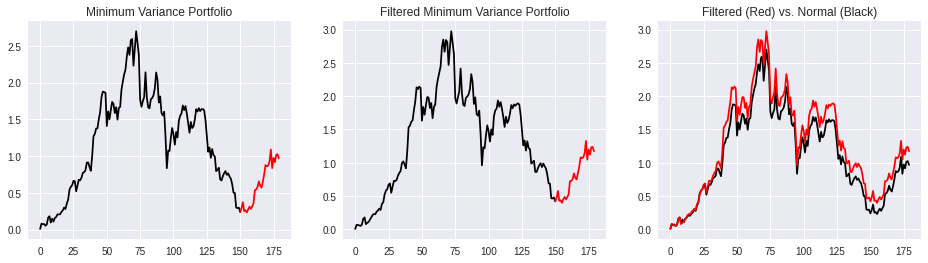

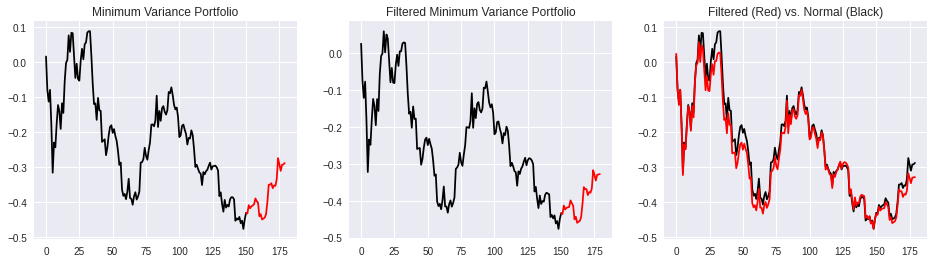

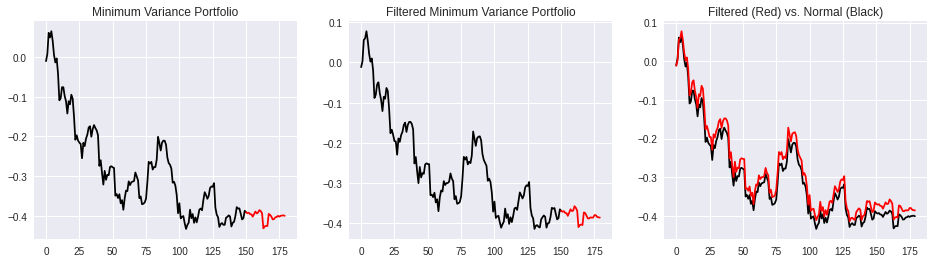

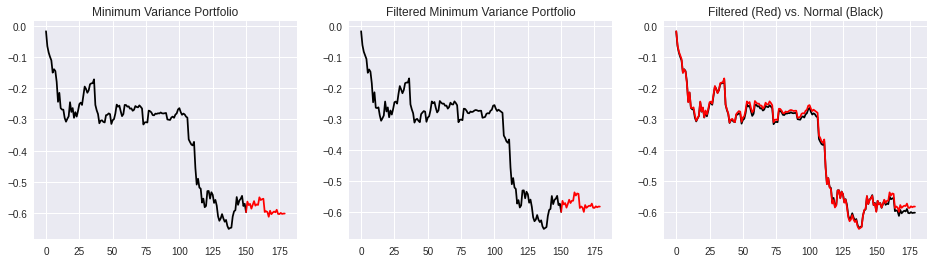

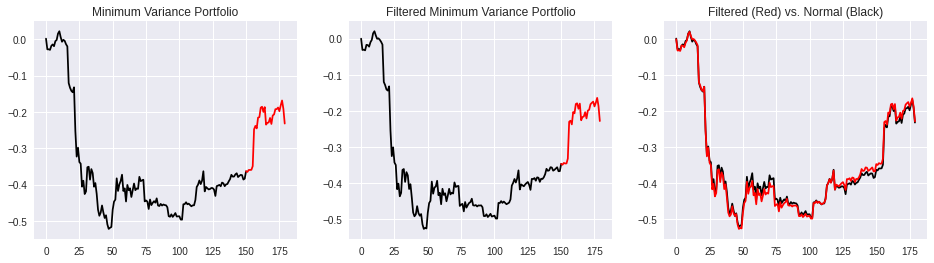

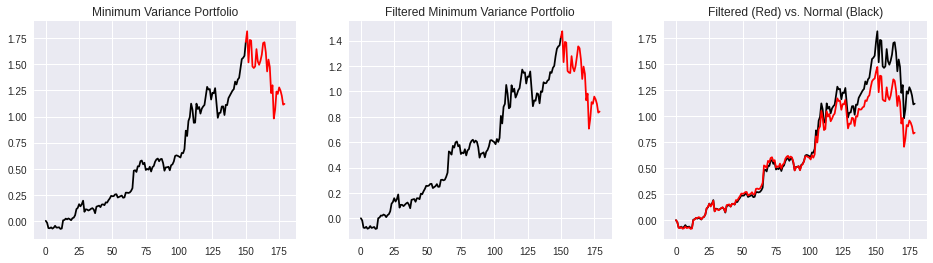

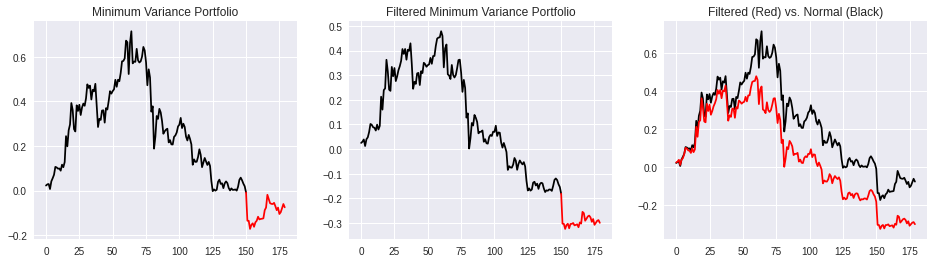

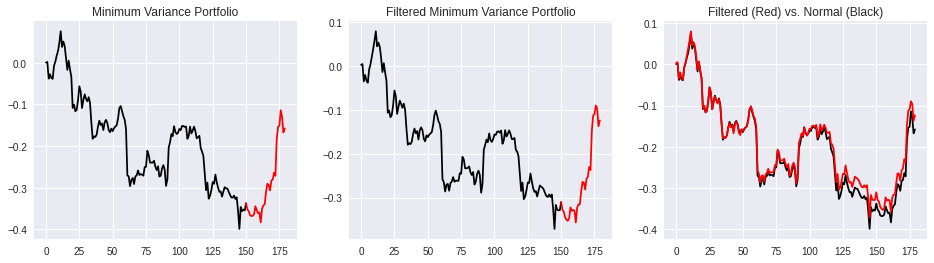

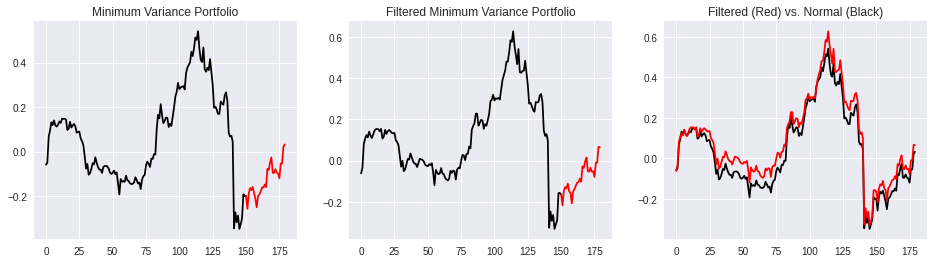

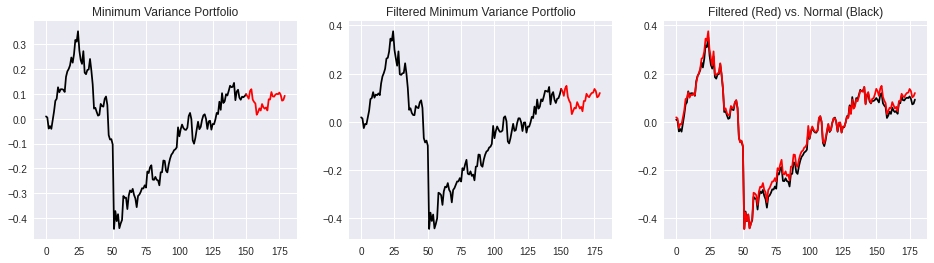

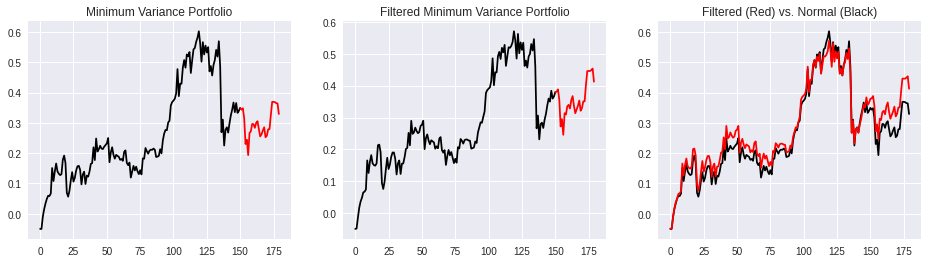

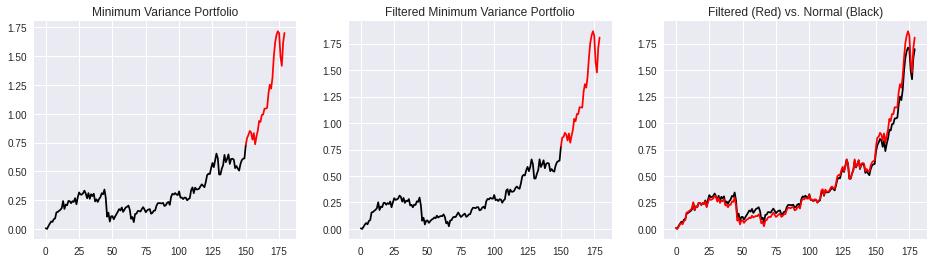

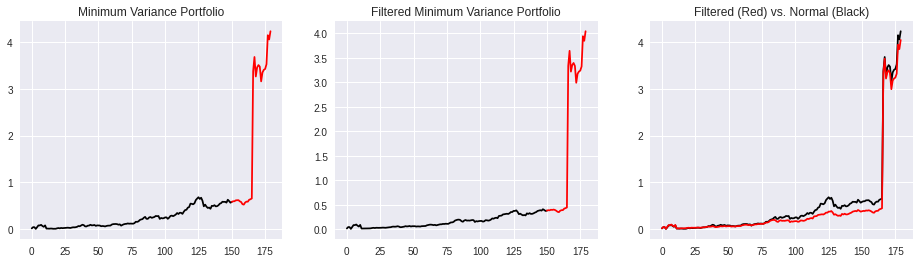

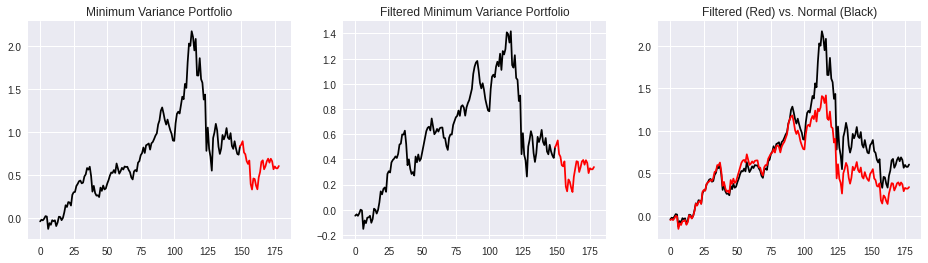

In [171]:
size = 180      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-90) if i < len(returns)-90]

[l_d.shape for l_d in list_of_dfs]
[create_filtered_portfolios(l_d, 30) for l_d in list_of_dfs]

[11.91664017]
[19.42026587]
[ 1.08822021 16.35094926]
[15.91152061]
[17.86297237]
[13.74604903]
[14.53554234]
[12.99224767]
[14.25997269]
[17.07281967]
[14.27780149]
[13.51037832]
[ 1.08359051  1.2035404   1.28325325  1.62583392 12.34383558]
[12.20055375]
[16.52494448]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

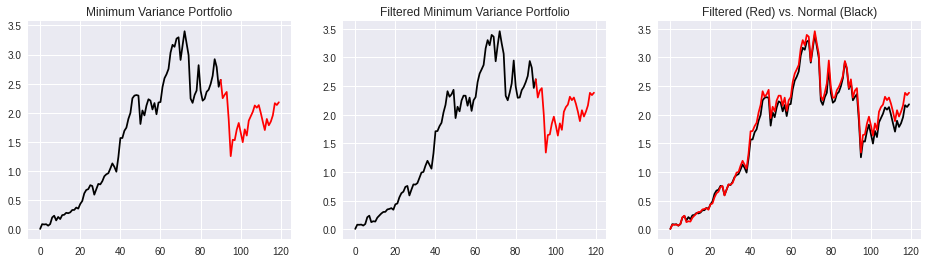

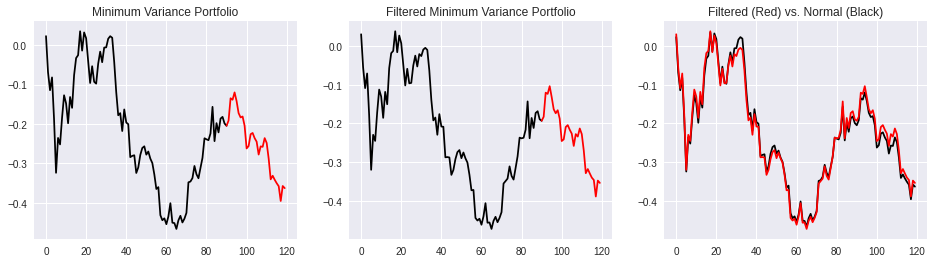

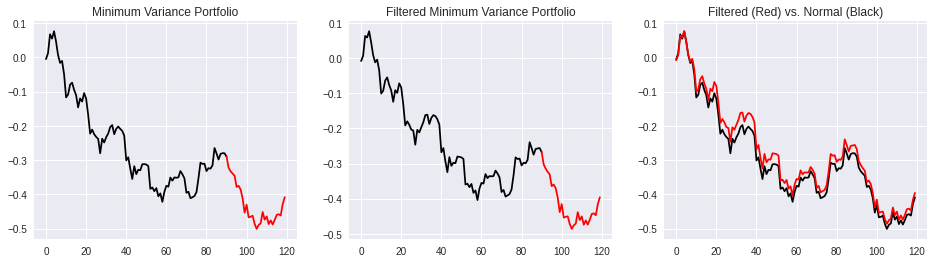

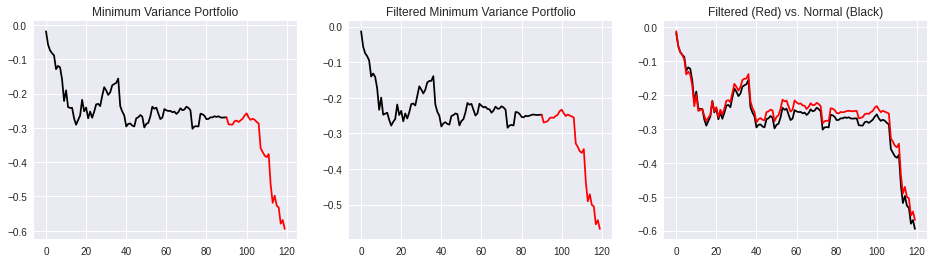

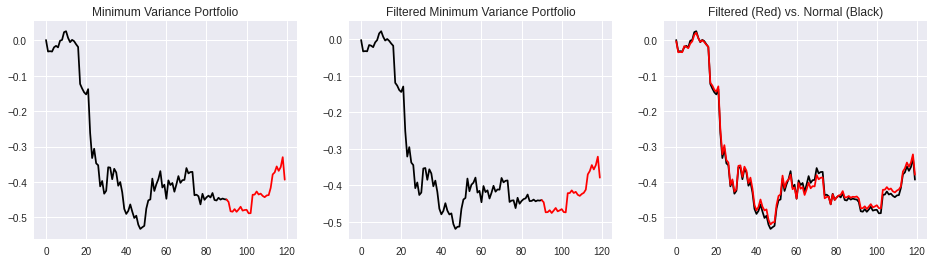

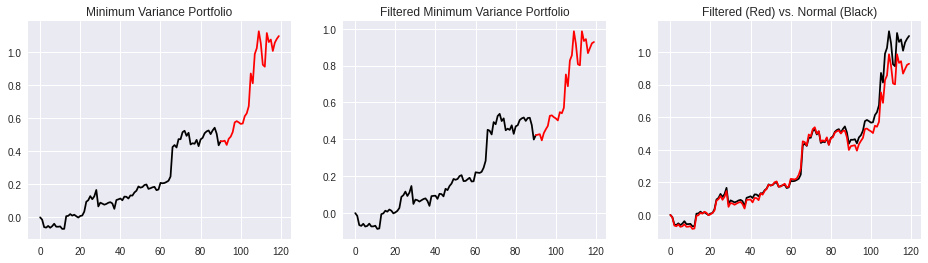

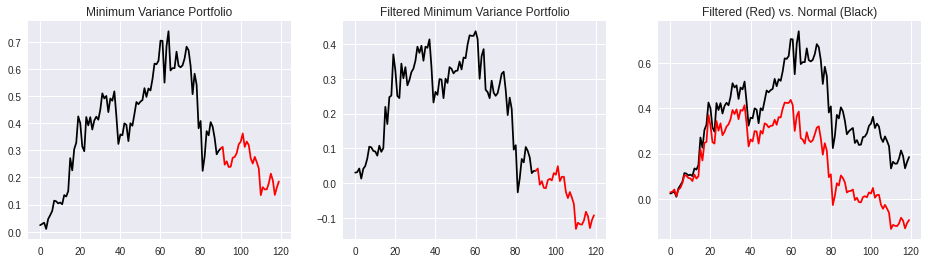

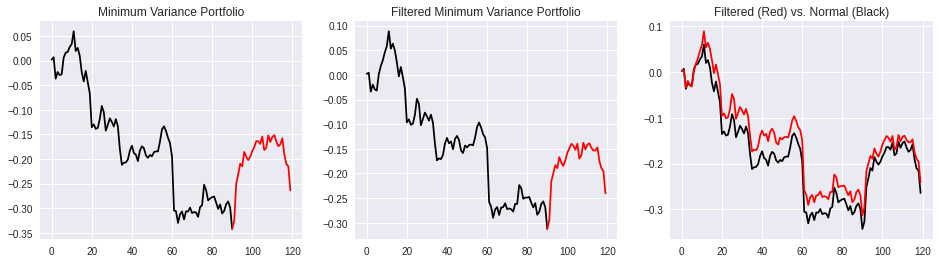

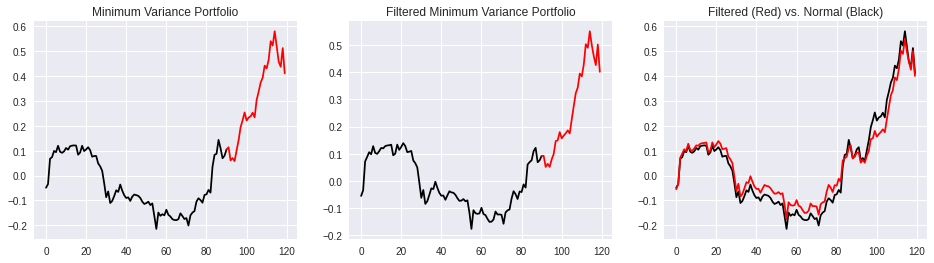

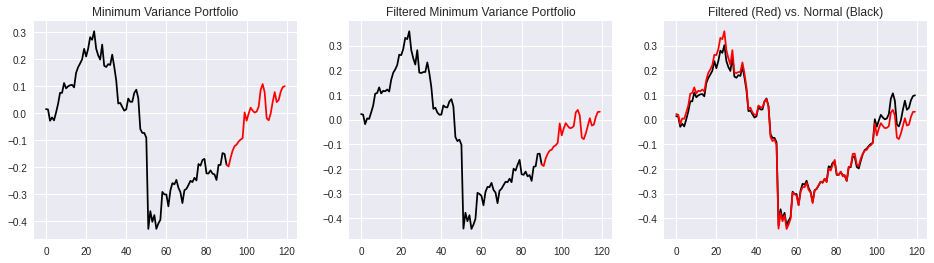

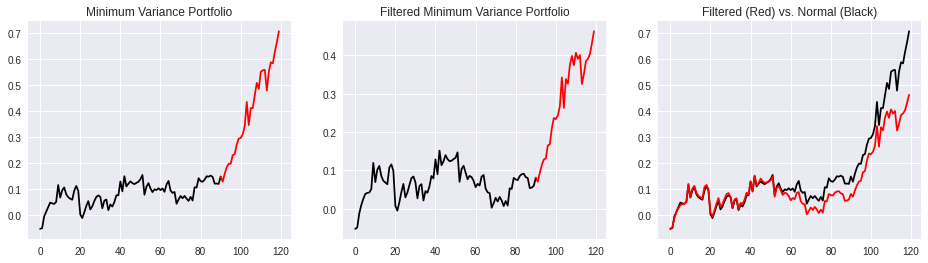

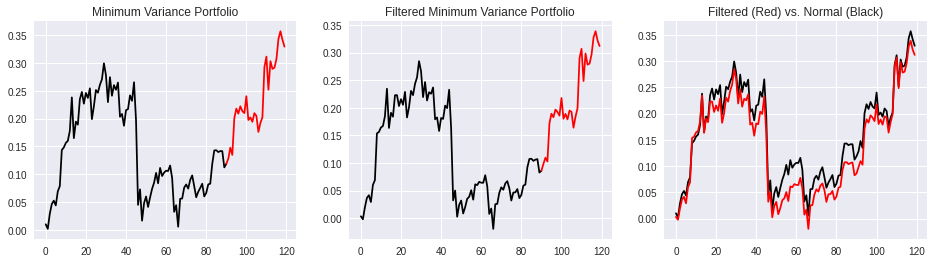

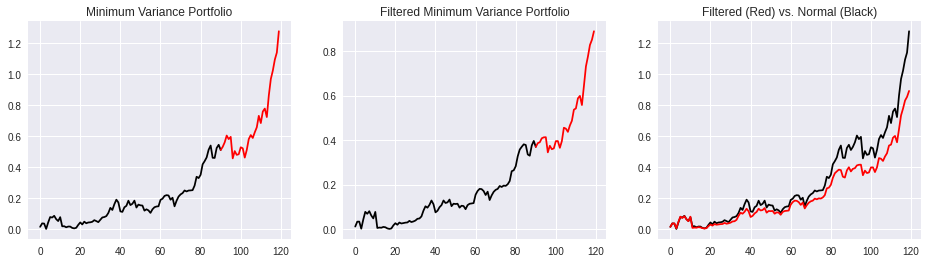

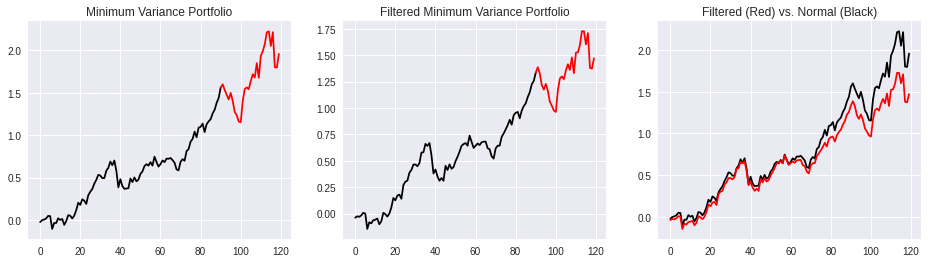

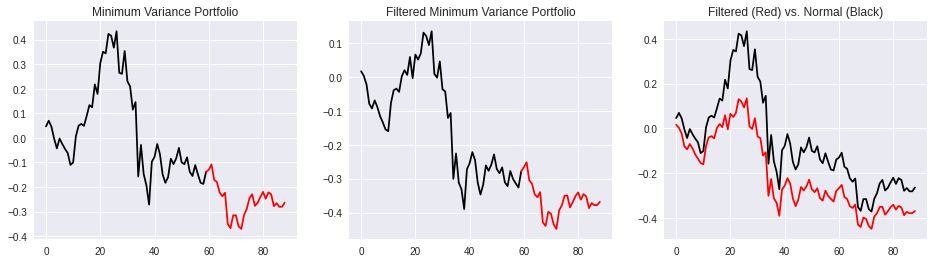

In [172]:
size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-30) if i < len(returns)-30]

[l_d.shape for l_d in list_of_dfs]
[create_filtered_portfolios(l_d, 30) for l_d in list_of_dfs]

### Ward Method

In [173]:
## First step is to calculate the distance matrix from the filtered matrix 
## next get condensed matrix from distance matrix (i.e the upper traingular of distance matrix)
def compute_distance_matrix(corr_mat, tickers):
    """
    Computes Correlation Matrix from the CC matrix, 
    and computes distance matrix from correlation matrix
    
    returns:
        - Distance matrix dataframe
    """
    
    ## Distance formula d(i,j) = 1-p(i,j)^2
    dist_mat = corr_mat
    for i in range(len(corr_mat)):
        for j in range(len(corr_mat)):
            dist_mat[i][j] = 1 - (corr_mat[i][j]**2)
    

    # add CC names
    df_dist_mat = pd.DataFrame(dist_mat, columns=tickers, index=tickers)
    
    return df_dist_mat

dist_mat_df = compute_distance_matrix(filtered_matrix.copy(), tickers)
# np.fill_diagonal(dist_mat_df.values, 0)
# import scipy.spatial.distance as ssd
# aa = ssd.squareform(dist_mat_df.values)

In [77]:
aa = dist_mat_df.copy()

In [78]:
aa = np.nan_to_num(aa.values)

In [79]:
aa

array([[0.        , 0.40355062, 0.6036517 , 0.47475041, 0.45172302,
        0.53976181, 0.66235948, 0.49057284, 0.63032694, 0.50657805,
        0.47592368, 0.56167186, 0.71301074, 0.63733504, 0.6169556 ,
        0.72540616, 0.60209874, 0.80817529, 0.76329861],
       [0.40355062, 0.        , 0.5363023 , 0.38549748, 0.35855716,
        0.46155592, 0.60498598, 0.40400853, 0.56751032, 0.42273342,
        0.38687012, 0.48718903, 0.66424414, 0.57570927, 0.55186686,
        0.67874586, 0.53448544, 0.77557951, 0.72307717],
       [0.6036517 , 0.5363023 , 0.        , 0.59165516, 0.57375297,
        0.64219698, 0.73750809, 0.60395599, 0.71260503, 0.61639892,
        0.59256729, 0.65923051, 0.77688591, 0.71805334, 0.70220975,
        0.78652248, 0.69065958, 0.85086969, 0.81598121],
       [0.47475041, 0.38549748, 0.59165516, 0.        , 0.43512795,
        0.52583147, 0.65213988, 0.47515367, 0.61913779, 0.49164331,
        0.46006111, 0.54840468, 0.70432424, 0.62635802, 0.60536174,
        0.717

In [80]:
import scipy.spatial.distance as ssd
cond = ssd.squareform(aa, checks=False)

In [81]:
cond.shape

(171,)

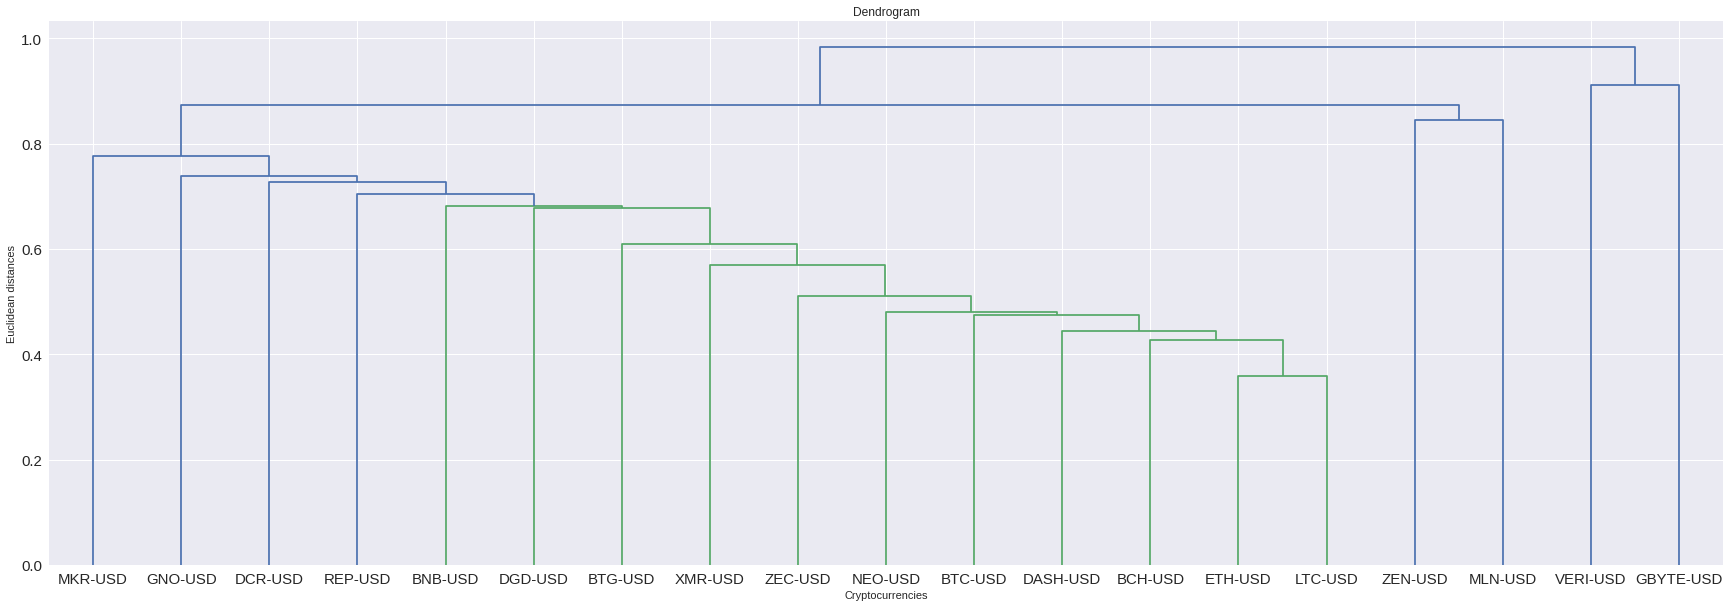

In [82]:
# Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and
# then in linkage we have to #specify on which data we apply and engage. 
# This is X dataset
import scipy.cluster.hierarchy as sch 
plt.figure(figsize=(30,10))

dendrogram = sch.dendrogram(sch.linkage(cond, method  = "ward"), labels = tickers)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Dendrogram')
plt.xlabel('Cryptocurrencies')
plt.ylabel('Euclidean distances')
plt.savefig('dendrogram.jpg')
plt.show()

In [83]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage ='ward')

In [84]:
np.reshape(cond, (-1, 1))

array([[0.40355062],
       [0.6036517 ],
       [0.47475041],
       [0.45172302],
       [0.53976181],
       [0.66235948],
       [0.49057284],
       [0.63032694],
       [0.50657805],
       [0.47592368],
       [0.56167186],
       [0.71301074],
       [0.63733504],
       [0.6169556 ],
       [0.72540616],
       [0.60209874],
       [0.80817529],
       [0.76329861],
       [0.5363023 ],
       [0.38549748],
       [0.35855716],
       [0.46155592],
       [0.60498598],
       [0.40400853],
       [0.56751032],
       [0.42273342],
       [0.38687012],
       [0.48718903],
       [0.66424414],
       [0.57570927],
       [0.55186686],
       [0.67874586],
       [0.53448544],
       [0.77557951],
       [0.72307717],
       [0.59165516],
       [0.57375297],
       [0.64219698],
       [0.73750809],
       [0.60395599],
       [0.71260503],
       [0.61639892],
       [0.59256729],
       [0.65923051],
       [0.77688591],
       [0.71805334],
       [0.70220975],
       [0.786

In [85]:
y_hc=hc.fit_predict(np.reshape(cond, (-1, 1)))

In [86]:
class_labels = ssd.squareform(y_hc, checks=False)[[0]]

In [87]:
some_list = list(zip(list(class_labels)[0], list(tickers)))

In [88]:
clusters_ward = pd.DataFrame(some_list, columns=['class_number', 'tickers'])


In [89]:
unstacked = clusters_ward.groupby(['class_number', 'tickers'])['tickers'].sum().unstack()

In [90]:
unstacked_2 = pd.concat([s.dropna().reset_index(drop=True) for i,s in unstacked.iterrows()], 1).T


In [91]:
unstacked_2.replace(np.nan, '', regex=True, inplace=True)

In [92]:
# unstacked_2.to_latex()

In [93]:
hd = dict()
for k in range(len(unstacked)):
    print(f'{k}: {unstacked.iloc[k].dropna().values}\n')


0: ['BTC-USD' 'GBYTE-USD' 'MLN-USD' 'ZEN-USD']

1: ['BTG-USD' 'XMR-USD']

2: ['VERI-USD']

3: ['BCH-USD' 'DASH-USD' 'LTC-USD' 'NEO-USD' 'ZEC-USD']

4: ['BNB-USD' 'DCR-USD' 'DGD-USD' 'GNO-USD' 'REP-USD']

5: ['ETH-USD']

6: ['MKR-USD']



In [94]:
filt_min_var_portfolio[filt_min_var_portfolio>0].dropna()

Investment Weight
BTC-USD             0.900082
ETH-USD             0.146893
BNB-USD             0.046568
LTC-USD             0.006378
XMR-USD             0.113998
MKR-USD             0.000593
DCR-USD             0.151675
ZEN-USD             0.064515
GNO-USD             0.055521
DGD-USD             0.009343
GBYTE-USD           0.065850

In [174]:
def ward_clustering(returns, test_period, tickers, **kwargs):
    
    print(f"Start period of window: {returns.index.min()}")
    # test_period = 30
    in_sample = returns.iloc[:(returns.shape[0]-test_period), :].copy()
    in_sample_log_returns = np.log(1+in_sample)

    # We will need the standard deviations later:
    variances = np.diag(in_sample_log_returns.cov().values)
    standard_deviations = np.sqrt(variances) 
    corr_mat = in_sample_log_returns.interpolate().corr('spearman')

    eVal0,eVec0=getPCA(corr_mat)
    q = returns.shape[0]/corr_mat.shape[0]

    # get bulk of Evalue and Variance
    eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
    # get nFacts
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)


    D, S = np.linalg.eigh(corr_mat)
    print(D[D > eMax0])
    # Filter the eigenvalues out
    D[D <= eMax0] = 0
    # Reconstruct the matrix
    temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))
    # Set the diagonal entries to 0
    np.fill_diagonal(temp, 1)
    filtered_matrix = temp


    # compute distance matrix
    dist_mat_df = compute_distance_matrix(filtered_matrix.copy(), tickers)

    aa = dist_mat_df.copy()
    # fill nan with 0s
    aa = np.nan_to_num(aa.values)

    import scipy.spatial.distance as ssd
    # convert to condensed matrix
    cond = ssd.squareform(aa, checks=False)

    # Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and
    # then in linkage we have to #specify on which data we apply and engage. 
    import scipy.cluster.hierarchy as sch 
    plt.figure(figsize=(30,10))

    # Create dendrogram
    dendrogram = sch.dendrogram(sch.linkage(cond, method  = "ward"), labels = tickers)

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title('Dendrogram')
    plt.xlabel('Cryptocurrencies')
    plt.ylabel('Euclidean distances')
#     plt.savefig(f'dendrogram_{dendo}.jpg')


    from sklearn.cluster import AgglomerativeClustering 
    # apply fixed number of clusters and fit cluster
    hc = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage ='ward')
    y_hc=hc.fit_predict(np.reshape(cond, (-1, 1)))

    class_labels = ssd.squareform(y_hc, checks=False)[[0]]
    some_list = list(zip(list(class_labels)[0], list(tickers)))
    clusters_ward = pd.DataFrame(some_list, columns=['class_number', 'tickers'])
#     display(clusters_ward)

    unstacked = clusters_ward.groupby(['class_number', 'tickers'])['tickers'].sum().unstack()
    unstacked_2 = pd.concat([s.dropna().reset_index(drop=True) for i,s in unstacked.iterrows()], 1).T
    unstacked_2.replace(np.nan, '', regex=True, inplace=True)
#     display(unstacked_2)
    
    return clusters_ward


In [64]:
result[['BTC', 'ETH', 'XRP', 'XMR']].log.plot()

KeyError: "None of [Index(['BTC', 'ETH', 'XRP', 'XMR'], dtype='object')] are in the [columns]"

In [73]:
pd.isna(result.iloc[1,0])

False

In [161]:
l_d.index.min()

Timestamp('2020-01-21 00:00:00', freq='D')

Start period of window: 2017-11-02 00:00:00
[11.91664017]
Start period of window: 2018-01-31 00:00:00
[19.42026587]
Start period of window: 2018-05-01 00:00:00
[ 1.08822021 16.35094926]
Start period of window: 2018-07-30 00:00:00
[15.91152061]
Start period of window: 2018-10-28 00:00:00
[17.86297237]
Start period of window: 2019-01-26 00:00:00
[13.74604903]
Start period of window: 2019-04-26 00:00:00
[14.53554234]
Start period of window: 2019-07-25 00:00:00
[12.99224767]
Start period of window: 2019-10-23 00:00:00
[14.25997269]
Start period of window: 2020-01-21 00:00:00
[17.07281967]
Start period of window: 2020-04-20 00:00:00
[14.27780149]
Start period of window: 2020-07-19 00:00:00
[13.51037832]
Start period of window: 2020-10-17 00:00:00
[ 1.08359051  1.2035404   1.28325325  1.62583392 12.34383558]
Start period of window: 2021-01-15 00:00:00
[12.20055375]
Start period of window: 2021-04-15 00:00:00
[16.52494448]


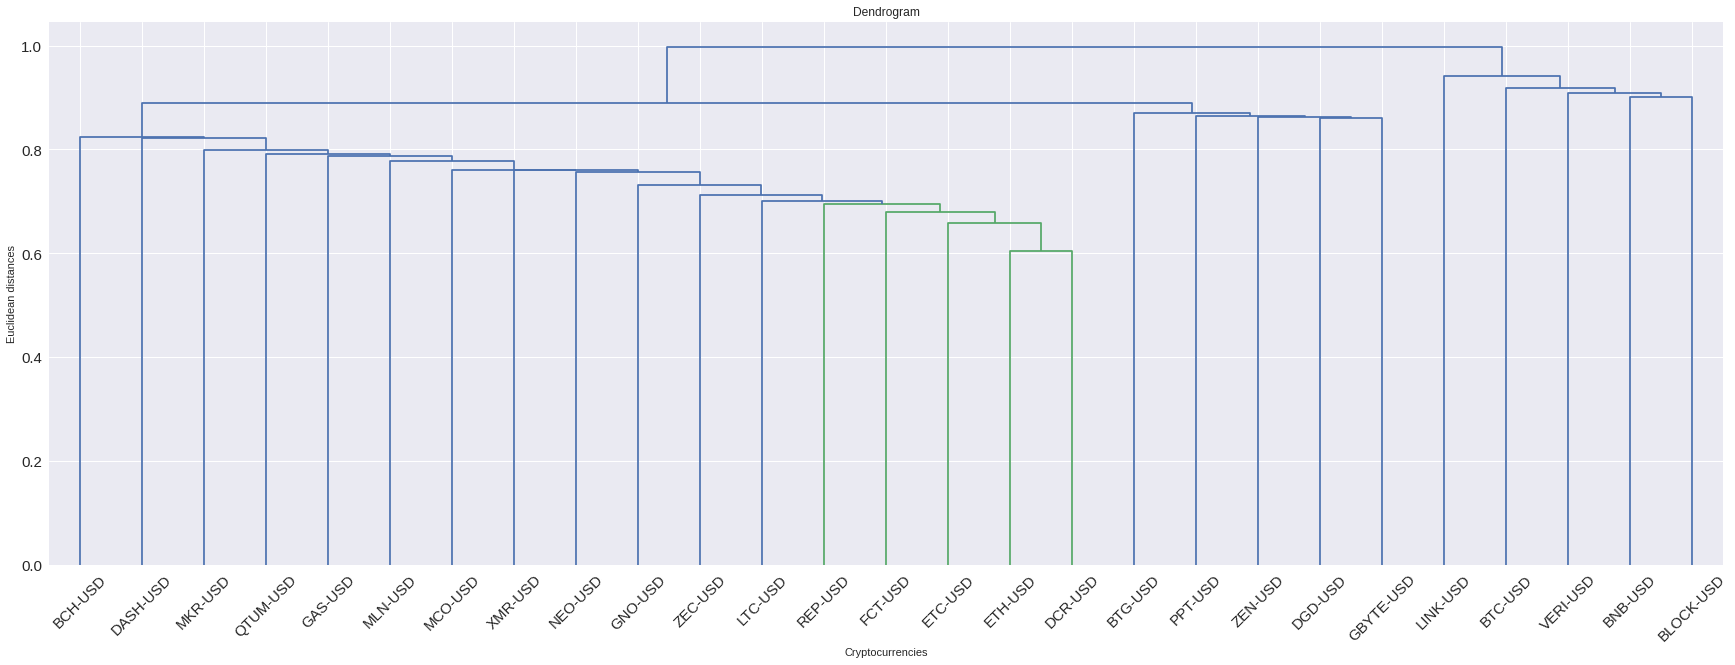

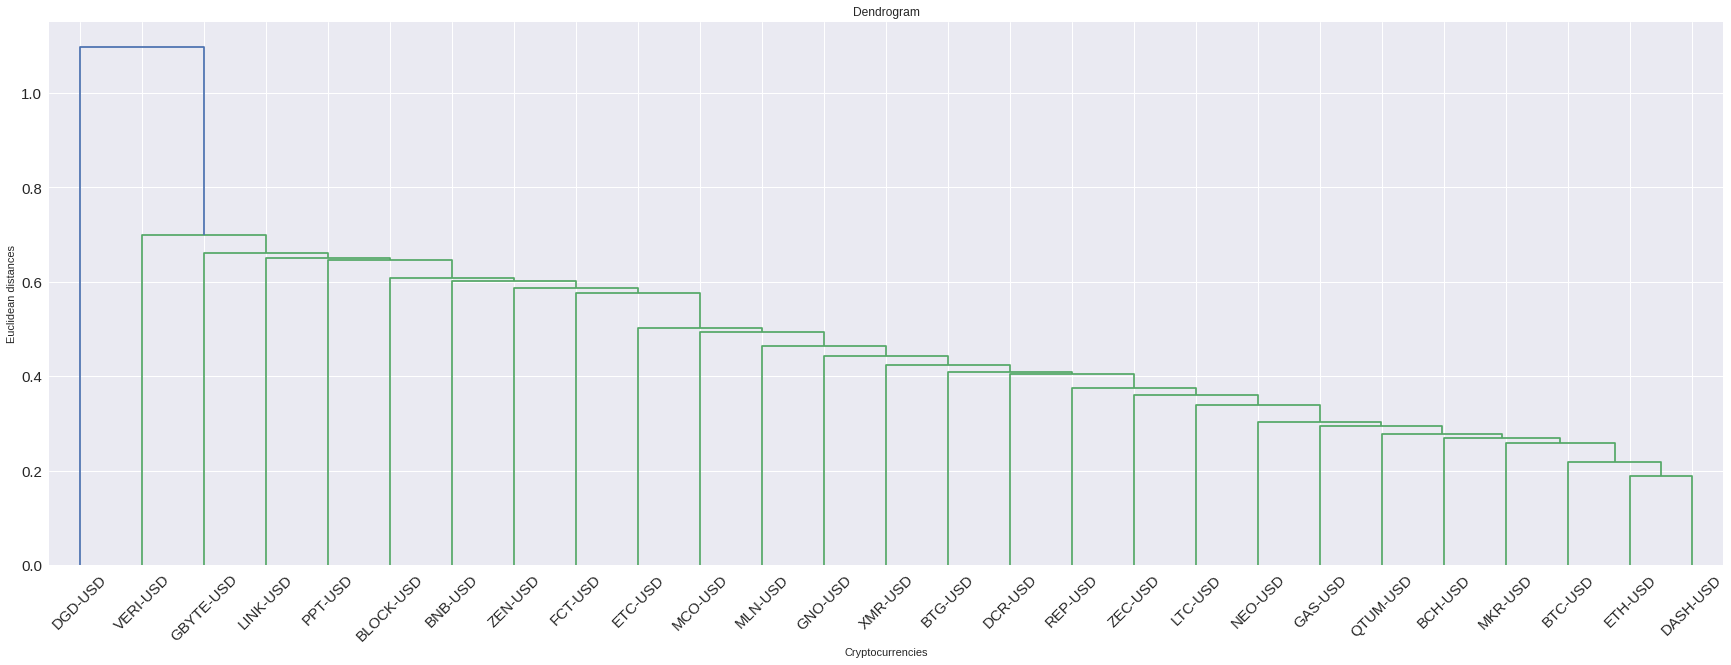

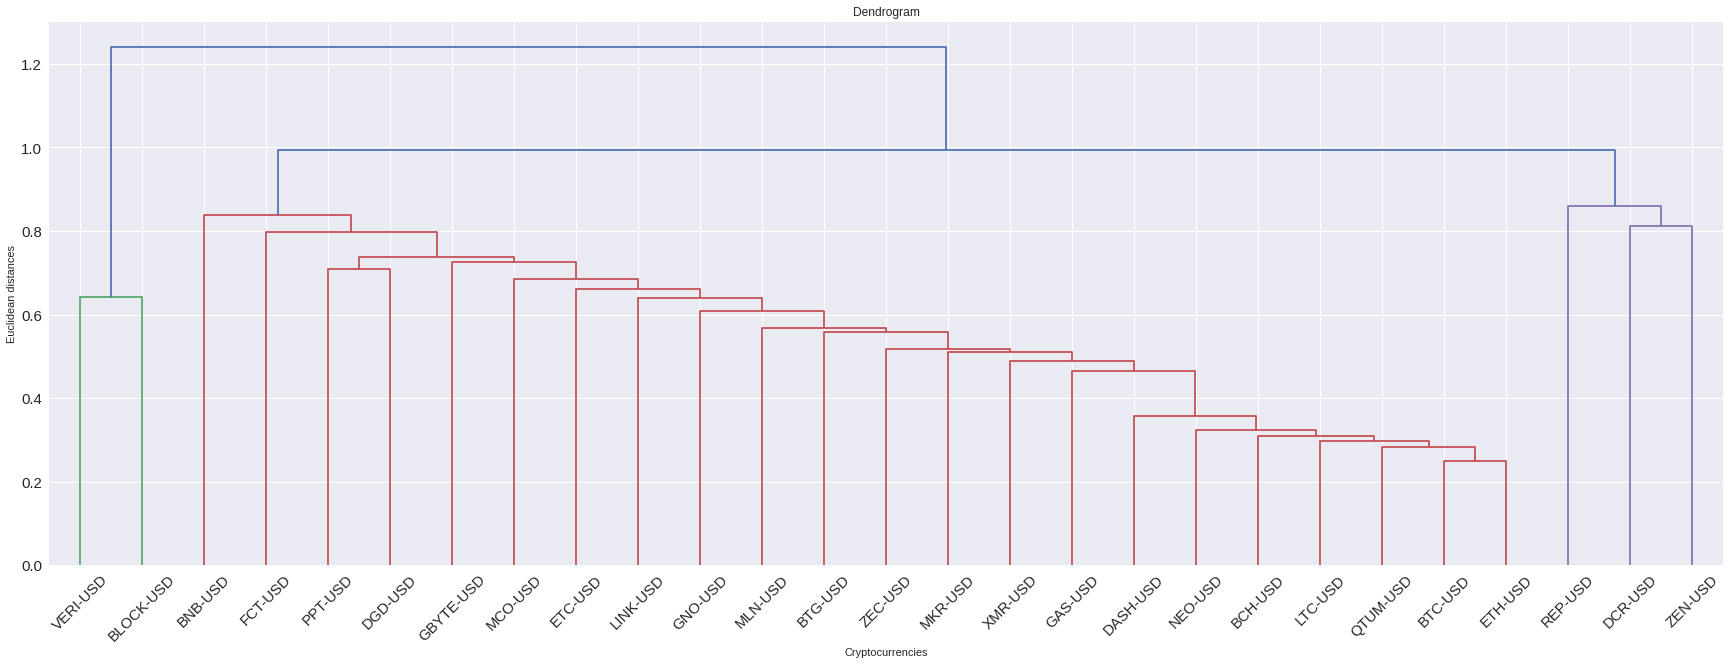

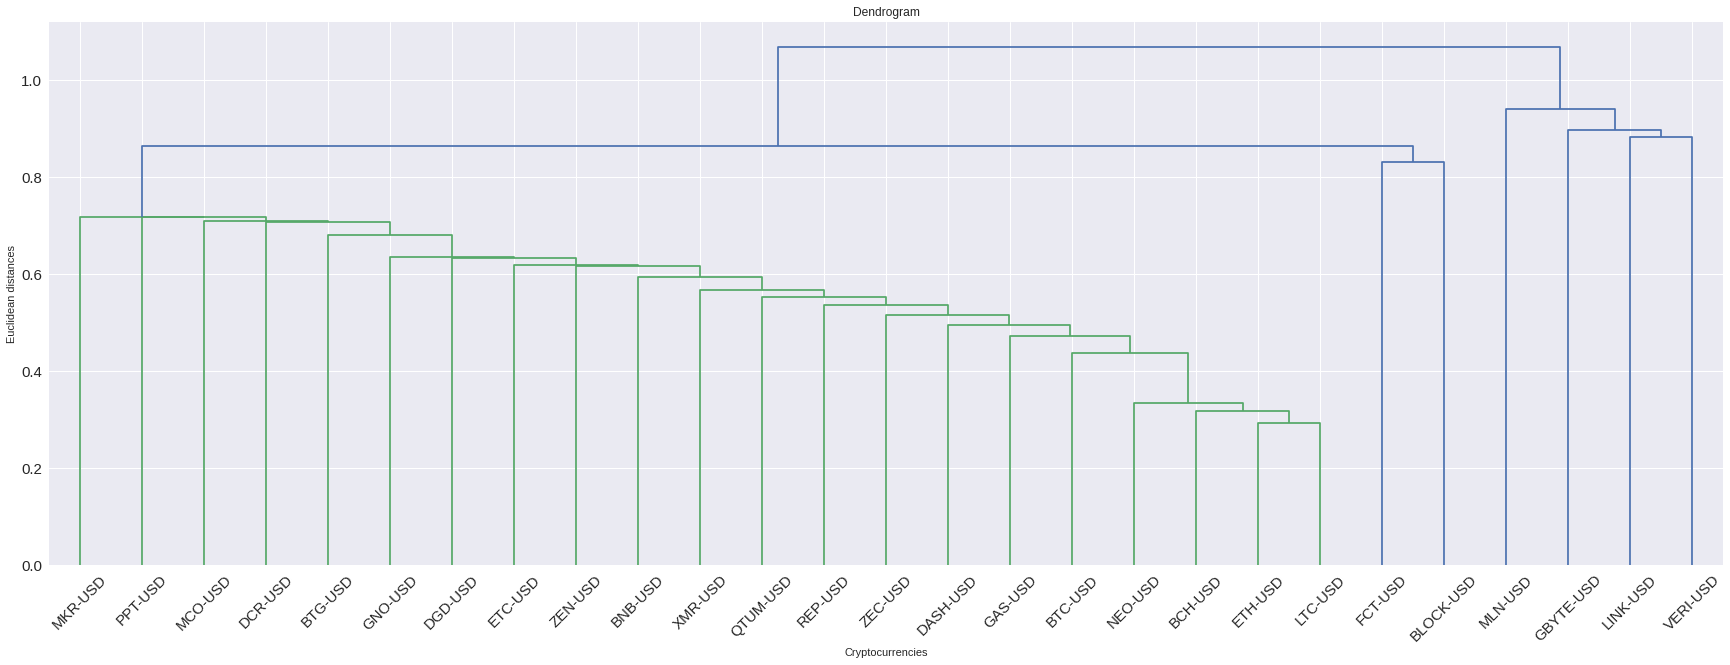

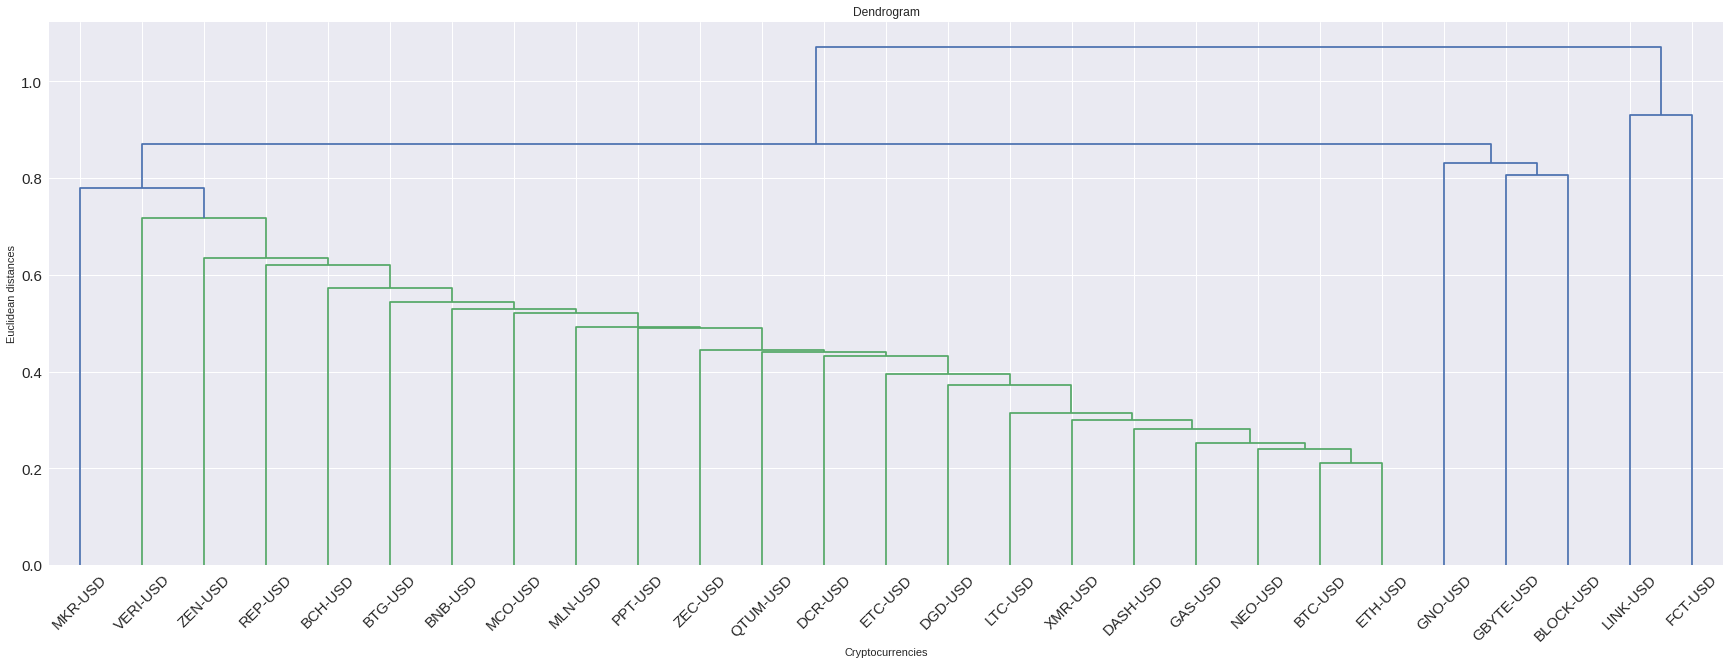

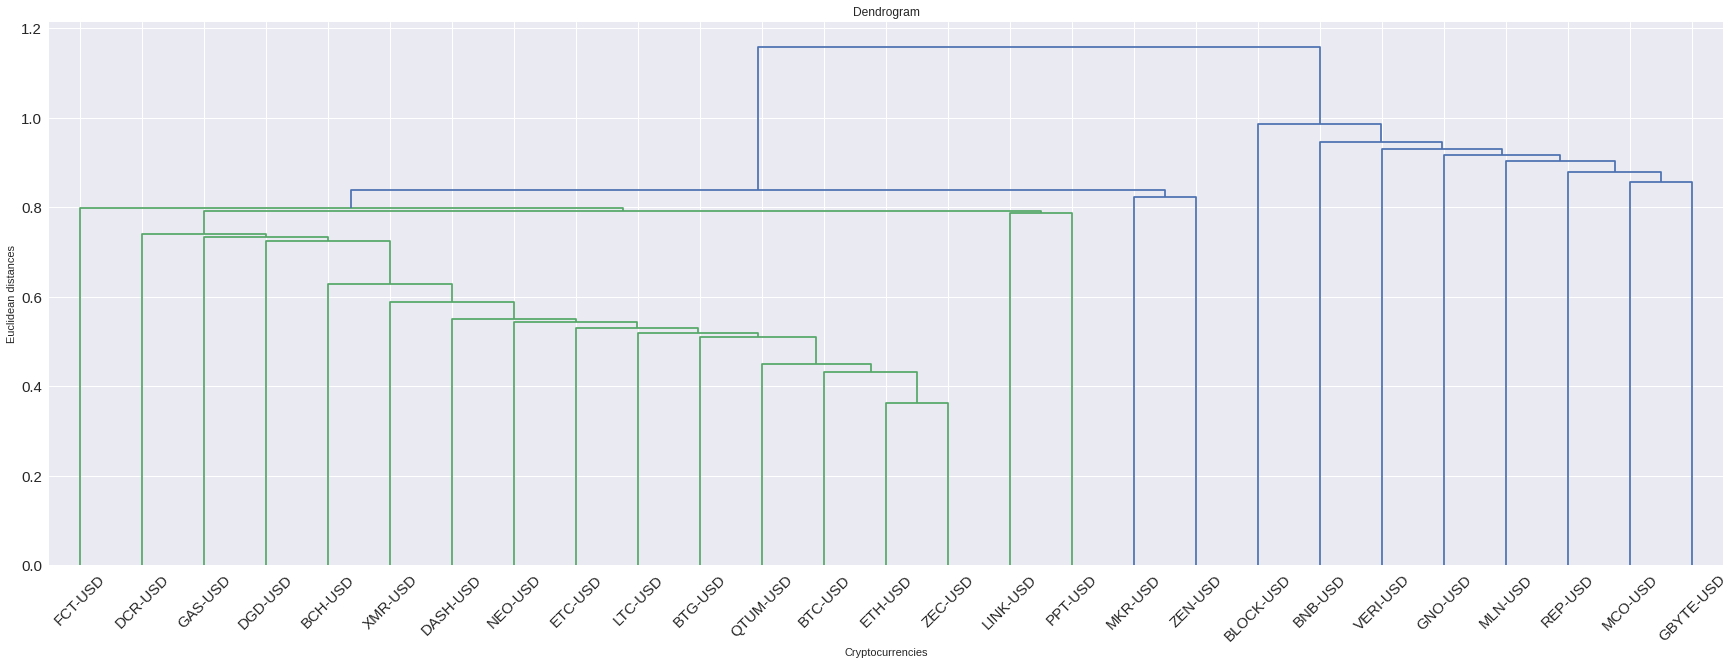

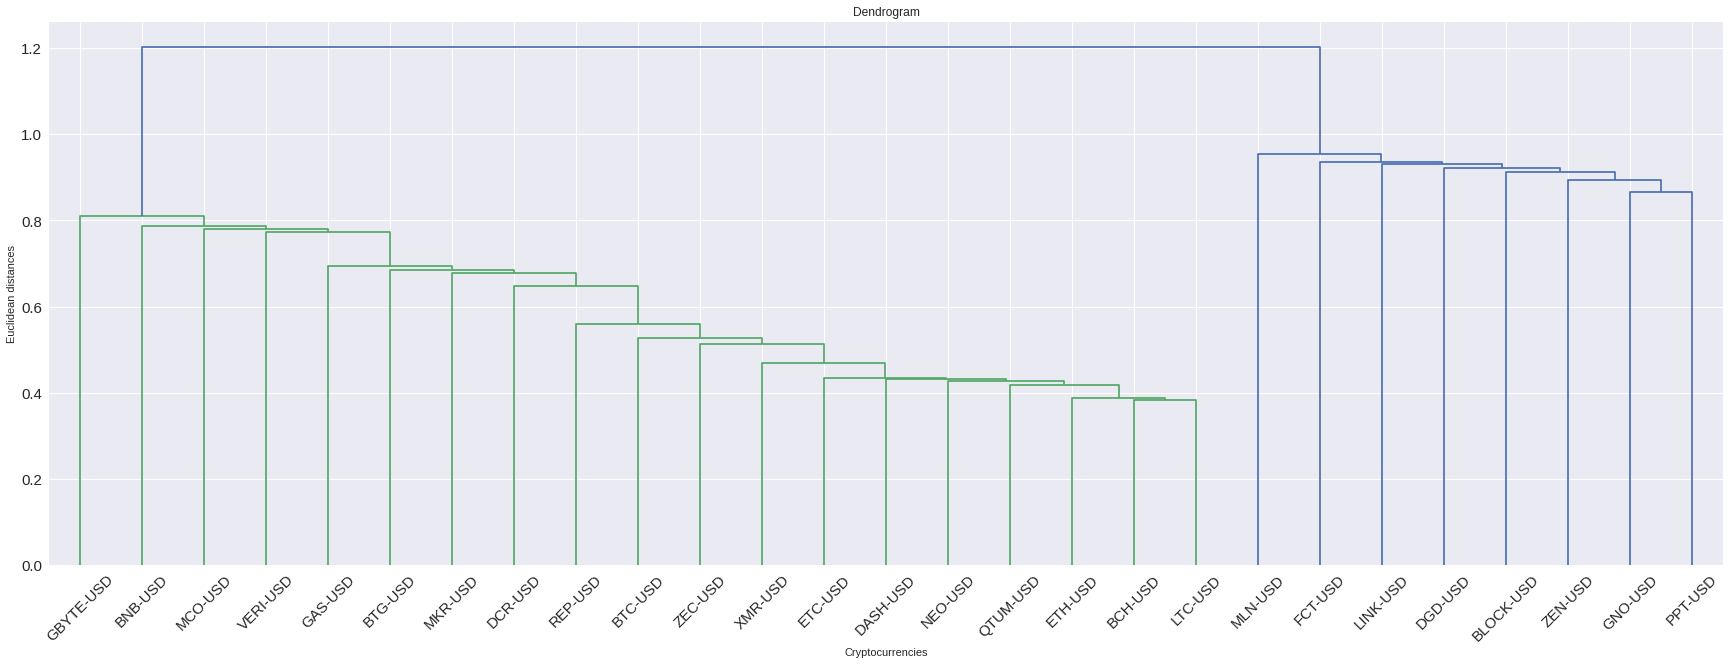

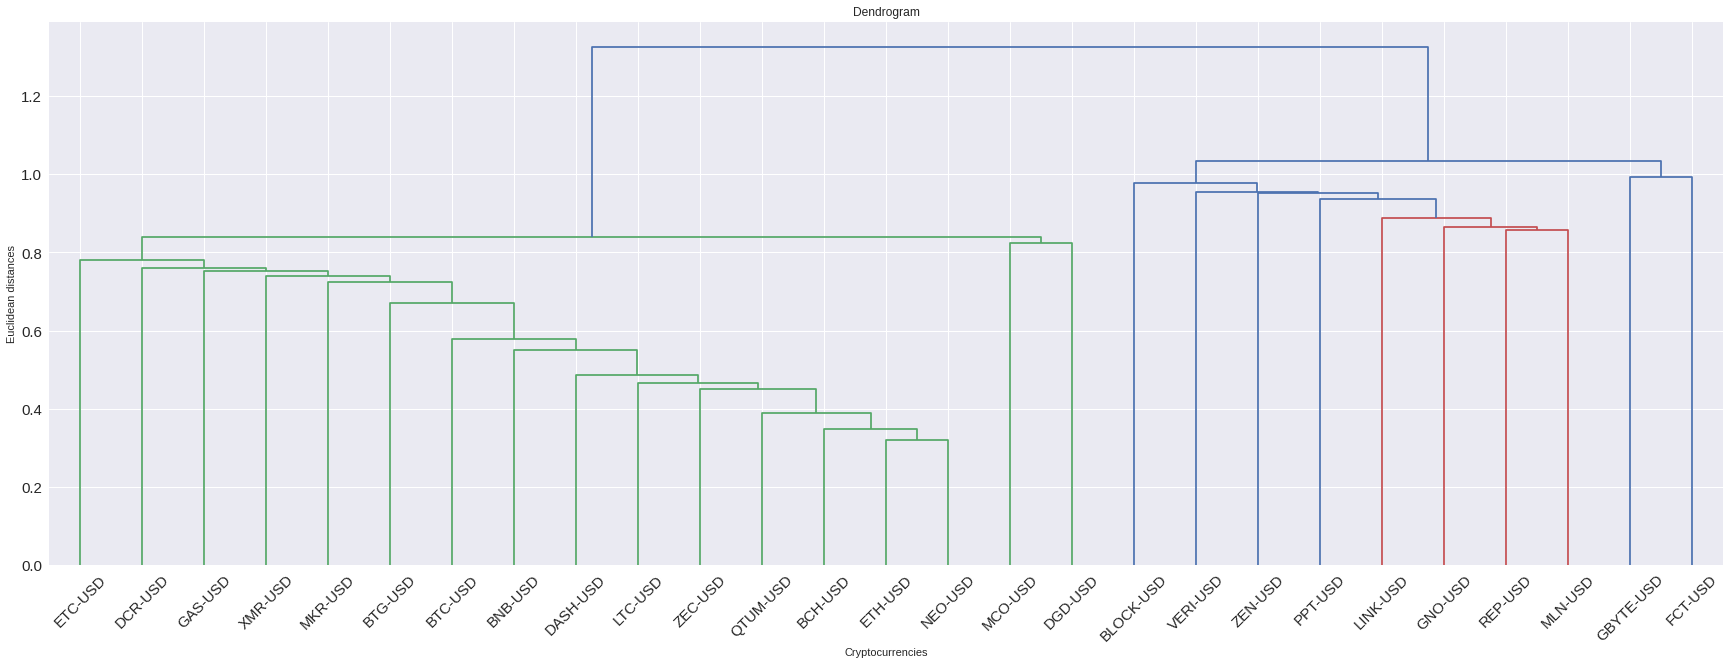

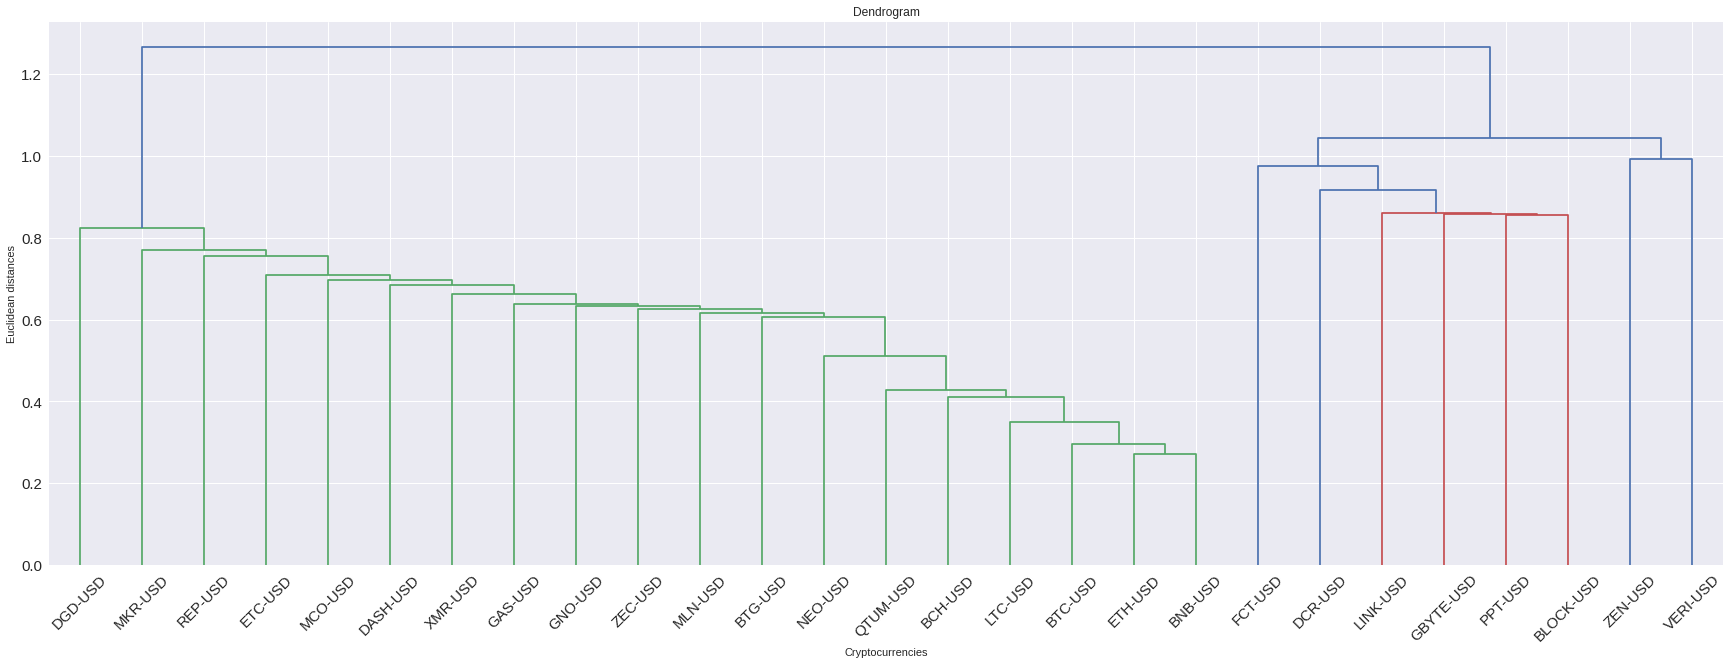

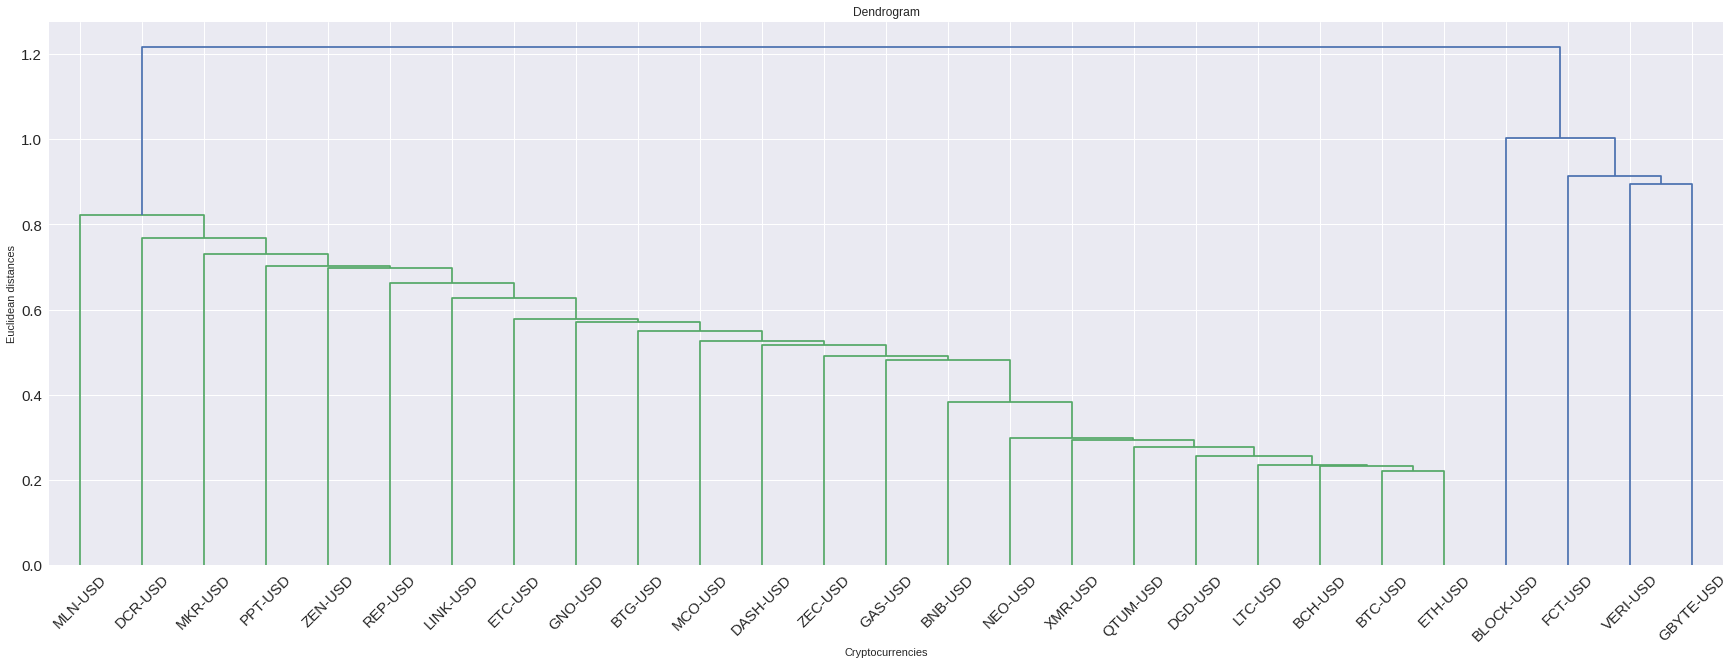

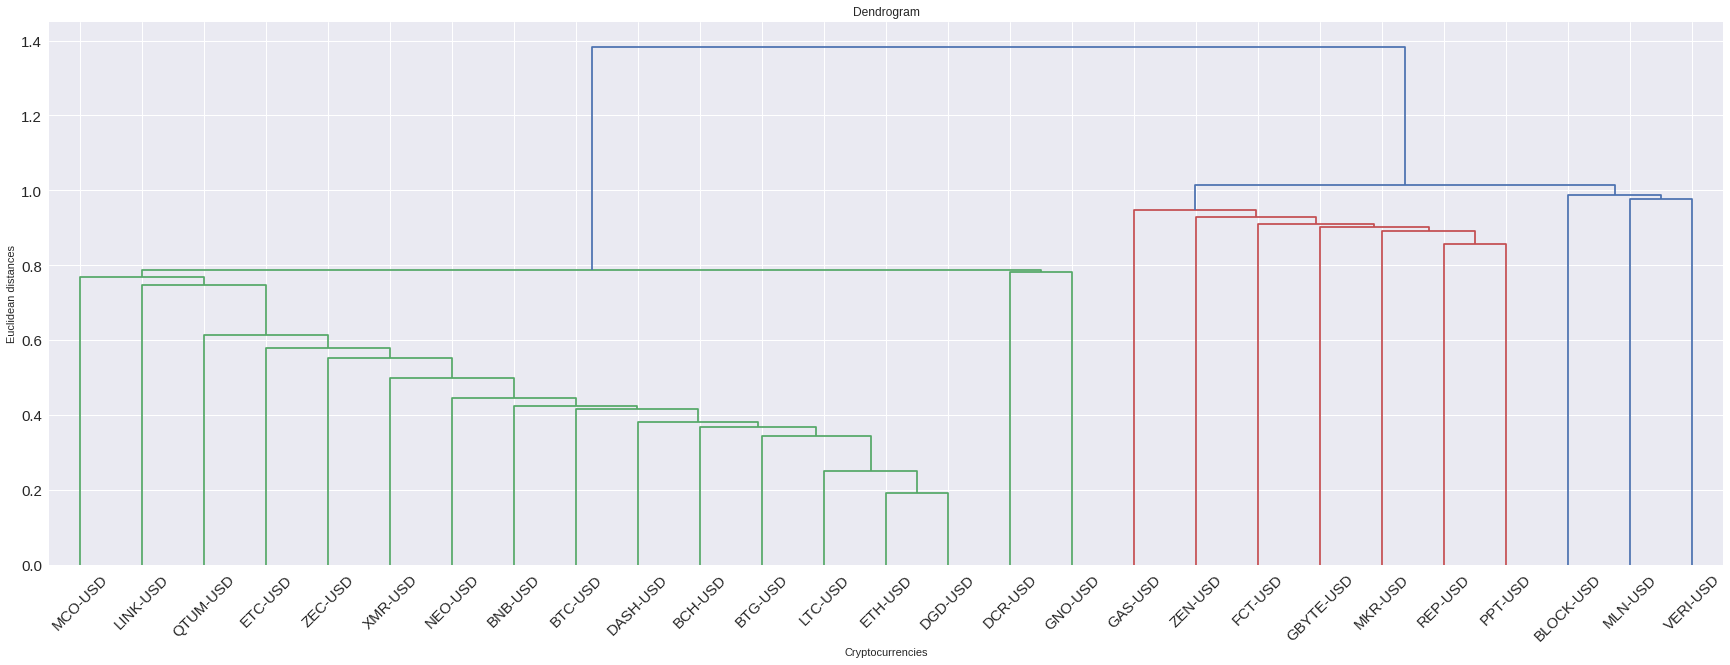

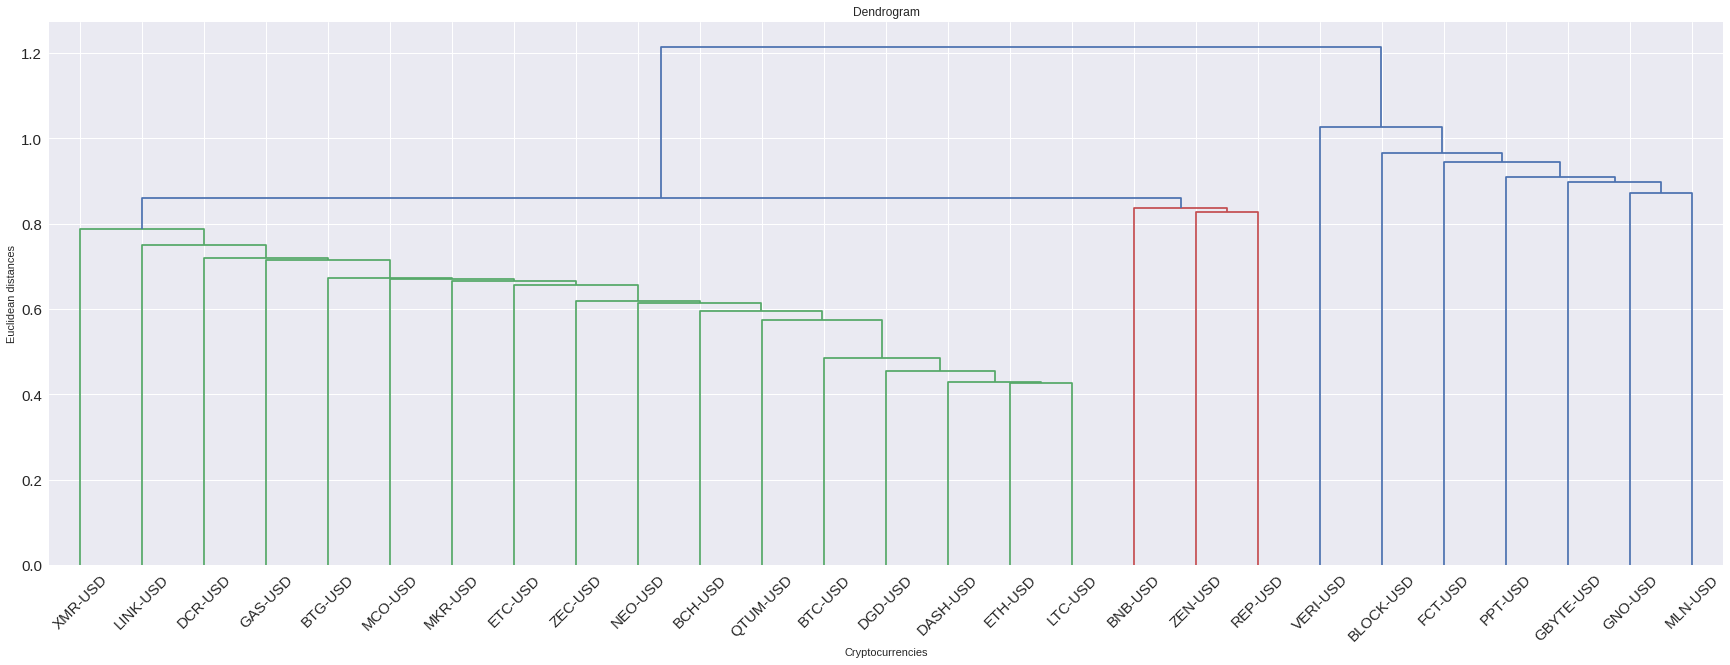

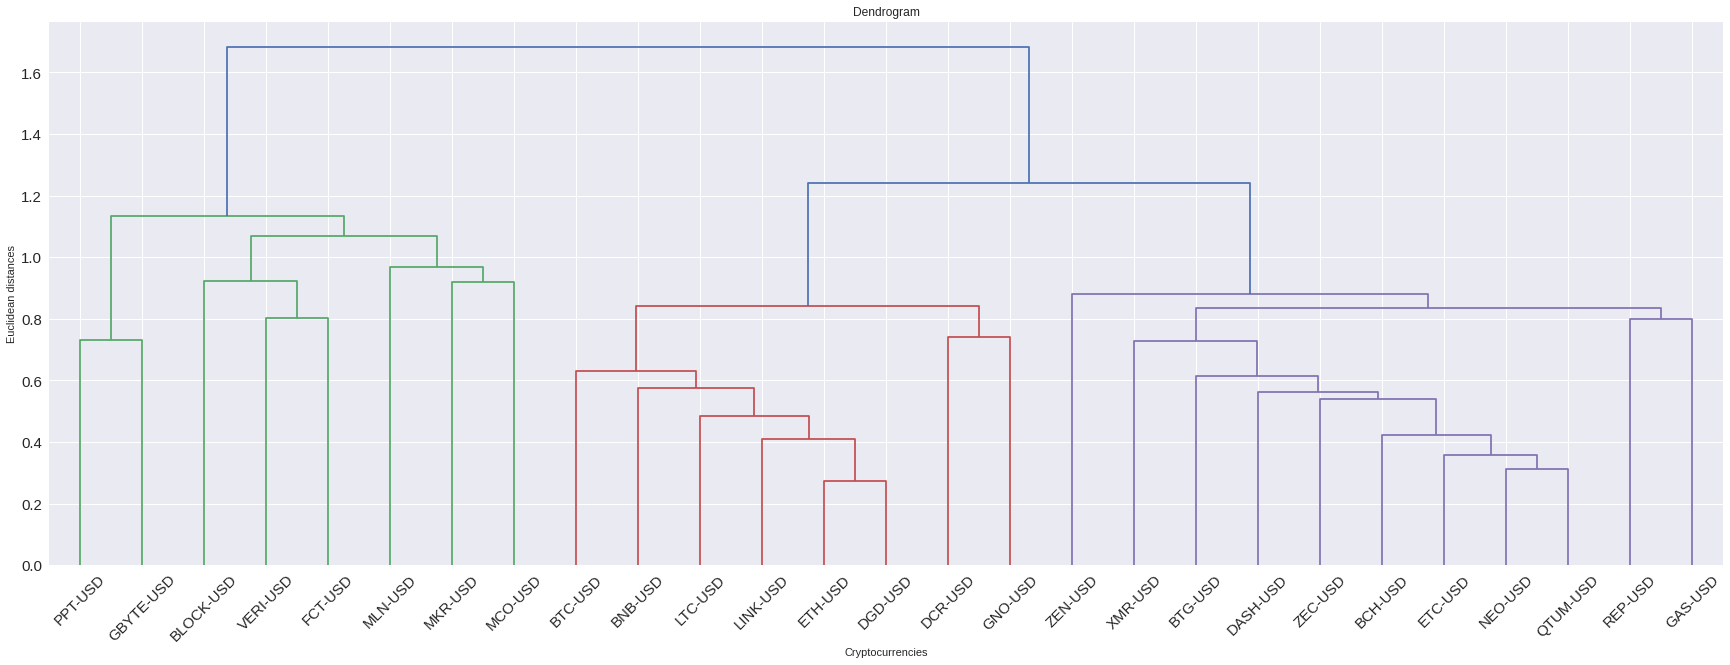

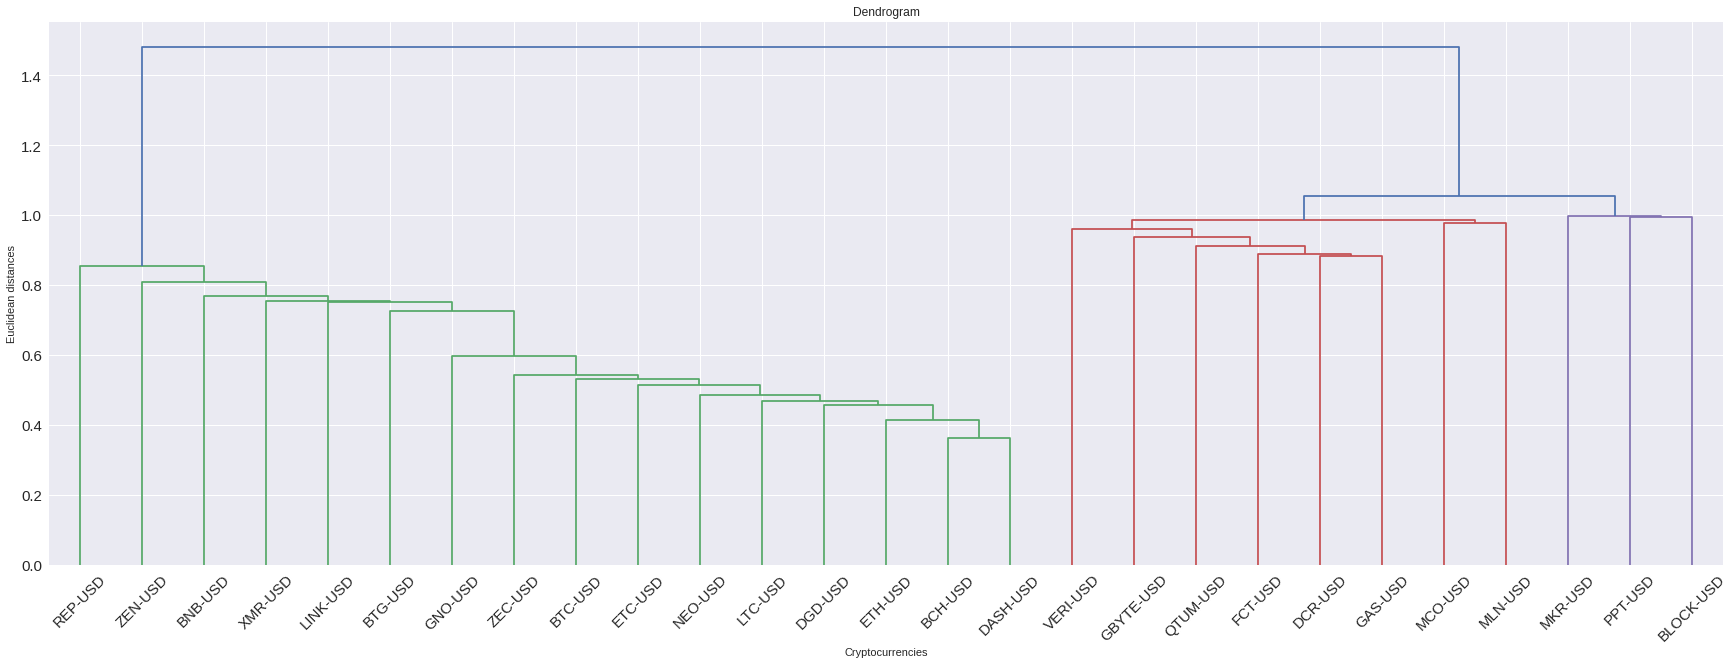

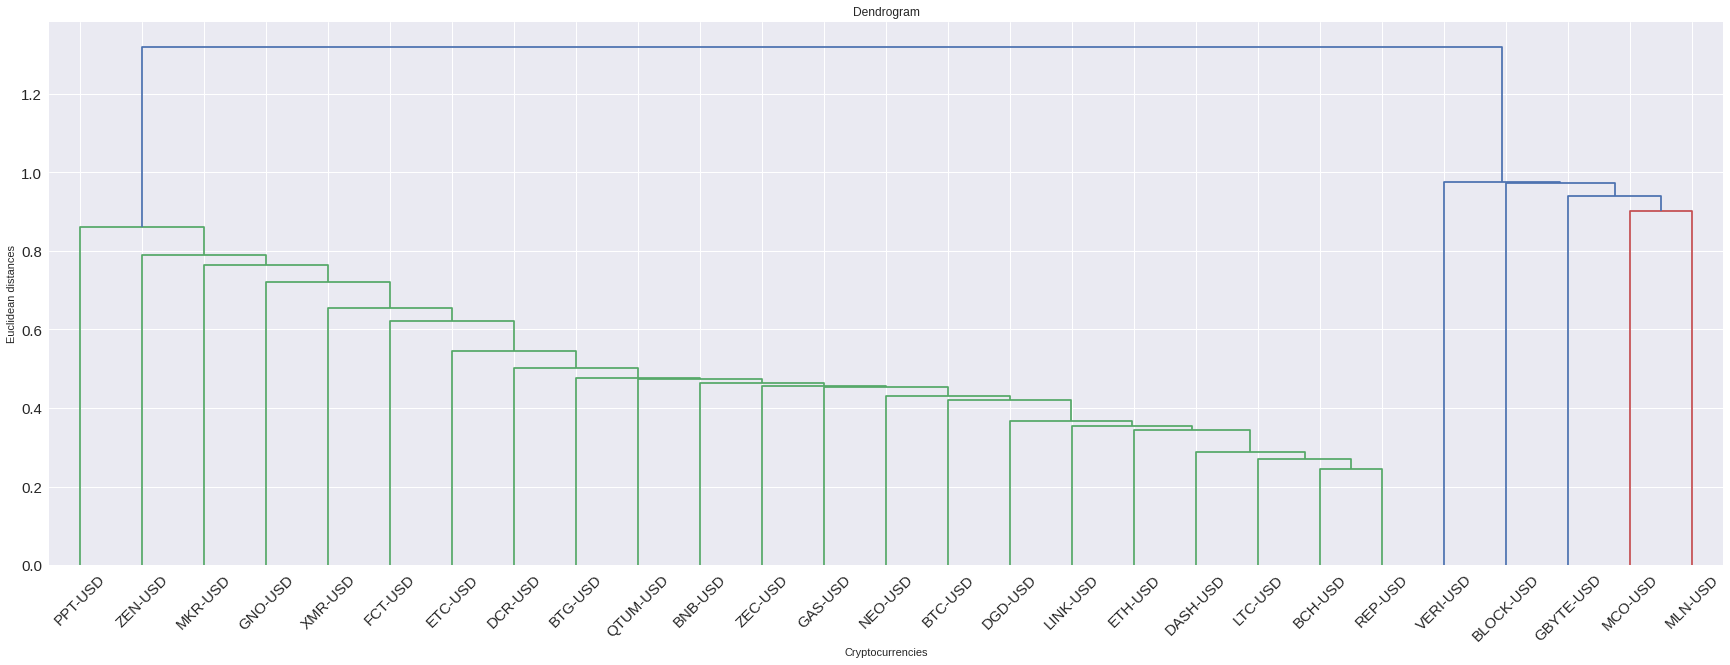

In [175]:
size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-30) if i < len(returns)-30]

[l_d.shape for l_d in list_of_dfs]
dendo = 0
clusters = []
for l_d in list_of_dfs:
    for col in l_d.columns:
        if (l_d[col].values == 0).all():
            l_d = l_d.drop(columns=col)
    tickers2 = l_d.columns
    clusters.append(ward_clustering(l_d, 30, tickers2, dendo=dendo) )
    dendo +=1

In [176]:
testp =clusters[0]

In [185]:
concat_df = pd.DataFrame()
for idx, testp in enumerate(clusters):
    pivot = testp.pivot_table(index='tickers', values='class_number').reset_index()
    pivot.columns = ['tickers', f'class_t{idx}']
    if idx == 0:
        concat_df = pivot
        continue
    concat_df = concat_df.merge(pivot, on=['tickers'], how='left')

In [186]:
concat_df.set_index('tickers')

class_t0  class_t1  class_t2  class_t3  class_t4  class_t5  \
tickers                                                                 
BCH-USD           0         0         2         5         2         0   
BLOCK-USD         0         4         1         4         1         1   
BNB-USD           0         4         5         6         0         5   
BTC-USD           0         0         0         0         0         0   
BTG-USD           0         3         3         6         0         7   
DASH-USD          0         0         2         3         5         7   
DCR-USD           4         3         6         0         0         0   
DGD-USD           0         2         0         6         0         0   
ETC-USD           4         7         0         6         0         7   
ETH-USD           7         0         2         5         5         3   
FCT-USD           4         4         5         4         4         2   
GAS-USD           6         0         3         3         5         0   
GBYTE-USD         0         6         0         1         3         4   
GNO-USD           6         3         3         6         3         6   
LINK-USD          0         4         0         4         6         2   
LTC-USD           4         0         2         5         5         7   
MCO-USD           6         7         0         0         0         4   
MKR-USD           6         0         3         0         1         2   
MLN-USD           6         3         3         1         0         6   
NEO-USD           6         0         2         5         5         7   
PPT-USD           0         4         0         0         0         2   
QTUM-USD          6         0         2         3         0         7   
REP-USD           4         0         6         3         2         4   
VERI-USD          0         6         1         4         1         6   
XMR-USD           6         3         3         3         5         0   
ZEC-USD           6         0         3         3         0         3   
ZEN-USD           0         4         5         6         2         2   

           class_t6  class_t7  class_t8  class_t9  class_t10  class_t11  \
tickers                                                                   
BCH-USD           1         2         0         1          4          3   
BLOCK-USD         6         0         4         3          3          1   
BNB-USD           0         4         0         1          4          0   
BTC-USD           0         0         0         0          0          0   
BTG-USD           0         4         7         0          4          7   
DASH-USD          7         2         3         0          4          4   
DCR-USD           5         7         6         2          0          7   
DGD-USD           6         6         4         1          1          4   
ETC-USD           7         7         3         0          7          7   
ETH-USD           1         2         0         1          1          4   
FCT-USD           2         0         5         7          2          6   
GAS-USD           0         7         7         0          2          7   
GBYTE-USD         0         5         4         5          2          2   
GNO-USD           3         6         7         0          0          2   
LINK-USD          2         3         2         0          0          0   
LTC-USD           1         2         0         1          4          4   
MCO-USD           0         6         3         0          0          7   
MKR-USD           0         7         3         6          2          7   
MLN-USD           2         6         7         2          6          2   
NEO-USD           7         2         0         1          4          3   
PPT-USD           3         3         4         6          5          6   
QTUM-USD          7         2         0         1          0          3   
REP-USD           5         6         3         6          5          0   
VERI-USD          

In [204]:
pd.crosstab(concat_df['class_t0'], ['class_t1'], values=concat_df['tickers'], aggfunc='count')

col_0     class_t1
class_t0          
0               12
4                5
6                9
7                1

In [190]:
concat_df.pivot(index=['tickers'], columns=['class_t1', 'class_t2'])

class_t0                                                         \
class_t1         0    4         0    3         2    7    0    6    4    0   
class_t2         2    1    5    0    3    6    0    0    3    0    0    6   
tickers                                                                     
BCH-USD        0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BLOCK-USD      NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BNB-USD        NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BTC-USD        NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BTG-USD        NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
DASH-USD       0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
DCR-USD        NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN   
DGD-USD        NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN   
ETC-USD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN   
ETH-USD        7.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
FCT-USD        NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
GAS-USD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN   
GBYTE-USD      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN   
GNO-USD        NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
LINK-USD       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN   
LTC-USD        4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
MCO-USD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN  NaN   
MKR-USD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN   
MLN-USD        NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
NEO-USD        6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
PPT-USD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN   
QTUM-USD       6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
REP-USD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0   
VERI-USD       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
XMR-USD        NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
ZEC-USD        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN   
ZEN-USD        NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

               class_t3                                                    \
class_t1     6        0    4         0    3         2    7    0    6    4   
class_t2     1        2    1    5    0    3    6    0    0    3    0    0   
tickers                                                                     
BCH-USD    NaN      5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BLOCK-USD  NaN      NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BNB-USD    NaN      NaN  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BTC-USD    NaN      NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BTG-USD    NaN      NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN   
DASH-USD   NaN      3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
DCR-USD    NaN      NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN   
DGD-USD    NaN      NaN  NaN  NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN  NaN   
ETC-USD    NaN      NaN  NaN  NaN  NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN   
ETH-USD    NaN      5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
FCT-USD    NaN      NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
GAS-USD    NaN      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN   
GBYTE-USD  NaN      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN   
GNO-USD    NaN      NaN  NaN  NaN  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN   
LINK-USD   NaN      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0   
LTC-USD    NaN      5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
MCO-USD    NaN      NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN   
MKR-U

In [112]:

unstacked = testp.groupby(['tickers', 'class_number'])['tickers'].sum().unstack()
unstacked
# unstacked_2 = pd.concat([s.dropna().reset_index(drop=True) for i,s in unstacked.iterrows()], 1).T
# unstacked_2
# unstacked_2.replace(np.nan, '', regex=True, inplace=True)

class_number        0        1         3        4          6
tickers                                                     
BCH-USD           NaN      NaN   BCH-USD      NaN        NaN
BNB-USD           NaN      NaN       NaN      NaN    BNB-USD
BTC-USD       BTC-USD      NaN       NaN      NaN        NaN
BTG-USD           NaN      NaN       NaN      NaN    BTG-USD
DASH-USD          NaN      NaN  DASH-USD      NaN        NaN
DCR-USD           NaN  DCR-USD       NaN      NaN        NaN
DGD-USD           NaN      NaN       NaN      NaN    DGD-USD
ETH-USD           NaN      NaN       NaN  ETH-USD        NaN
GBYTE-USD         NaN      NaN       NaN      NaN  GBYTE-USD
GNO-USD           NaN      NaN   GNO-USD      NaN        NaN
LTC-USD           NaN  LTC-USD       NaN      NaN        NaN
MKR-USD           NaN      NaN   MKR-USD      NaN        NaN
MLN-USD           NaN      NaN   MLN-USD      NaN        NaN
NEO-USD           NaN      NaN   NEO-USD      NaN        NaN
REP-USD           NaN  REP-USD       NaN      NaN        NaN
VERI-USD          NaN      NaN       NaN      NaN   VERI-USD
XMR-USD           NaN      NaN   XMR-USD      NaN        NaN
ZEC-USD           NaN  ZEC-USD       NaN      NaN        NaN
ZEN-USD           NaN      NaN       NaN      NaN    ZEN-USD

In [90]:
test_df = list_of_dfs[0]

In [102]:
for col in test_df.columns:
    if (test_df[col].values == 0).all():
        test_df = test_df.drop(columns=col)
        print(col)

[40.91840492]


0        1          2          3          4        5         6   \
0   ARK-USD  BTC-USD    CVC-USD    OMG-USD    XEM-USD                      
1    AE-USD  ANT-USD   ARDR-USD    BCN-USD  BLOCK-USD  BNB-USD   BTM-USD   
3  AION-USD  BCH-USD    BTG-USD  BURST-USD    DCN-USD  ICX-USD   KIN-USD   
4   ADA-USD  ADX-USD    BAT-USD    BNT-USD    DCR-USD  DNT-USD  DOGE-USD   
6   HNC-USD  PAC-USD  SMART-USD    XTZ-USD    XWC-USD                      

         7         8         9         10        11        12       13  \
0                                                                        
1   BTS-USD  DASH-USD   DGB-USD   DGD-USD   ENJ-USD   EOS-USD  ETC-USD   
3  LINK-USD  MANA-USD  MONA-USD  NANO-USD  NEBL-USD  NULS-USD  NXT-USD   
4   ETH-USD   ETP-USD   FCT-USD  GAME-USD   GRS-USD   LSK-USD  MTL-USD   
6                                                                        

         14       15         16         17        18       19       20  \
0                                                                        
1   FUN-USD  GAS-USD  GBYTE-USD    GNO-USD    HC-USD  KMD-USD  KNC-USD   
3  PART-USD  SBD-USD  SNGLS-USD    TRX-USD  VERI-USD  XVG-USD            
4   PAY-USD  RLC-USD    SNT-USD  STEEM-USD   SYS-USD  UBQ-USD  VTC-USD   
6                                                                        

        21       22        23       24         25       26       27       28  \
0                                                                              
1  LRC-USD  LTC-USD  MAID-USD  MCO-USD  MIOTA-USD  MKR-USD  MLN-USD  NAV-USD   
3                                                                              
4                                                                              
6                                                                              

        29       30        31       32       33        34       35       36  \
0                                                                             
1  NEO-USD  NXS-USD  PIVX-USD  PPT-USD  QRL-USD  QTUM-USD  RDD-USD  REP-USD   
3                                                                             
4                                                                             
6                                                                             

         37      38       39         40         41       42       43       44  \
0                                                                               
1  SALT-USD  SC-USD  SNM-USD  STORJ-USD  WAVES-USD  WTC-USD  XLM-USD  XMR-USD   
3                                                                               
4                                                                               
6                                                                               

        45       46       47       48  
0                                      
1  XRP-USD  ZEC-USD  ZEN-USD  ZRX-USD  
3                                      
4                                      
6

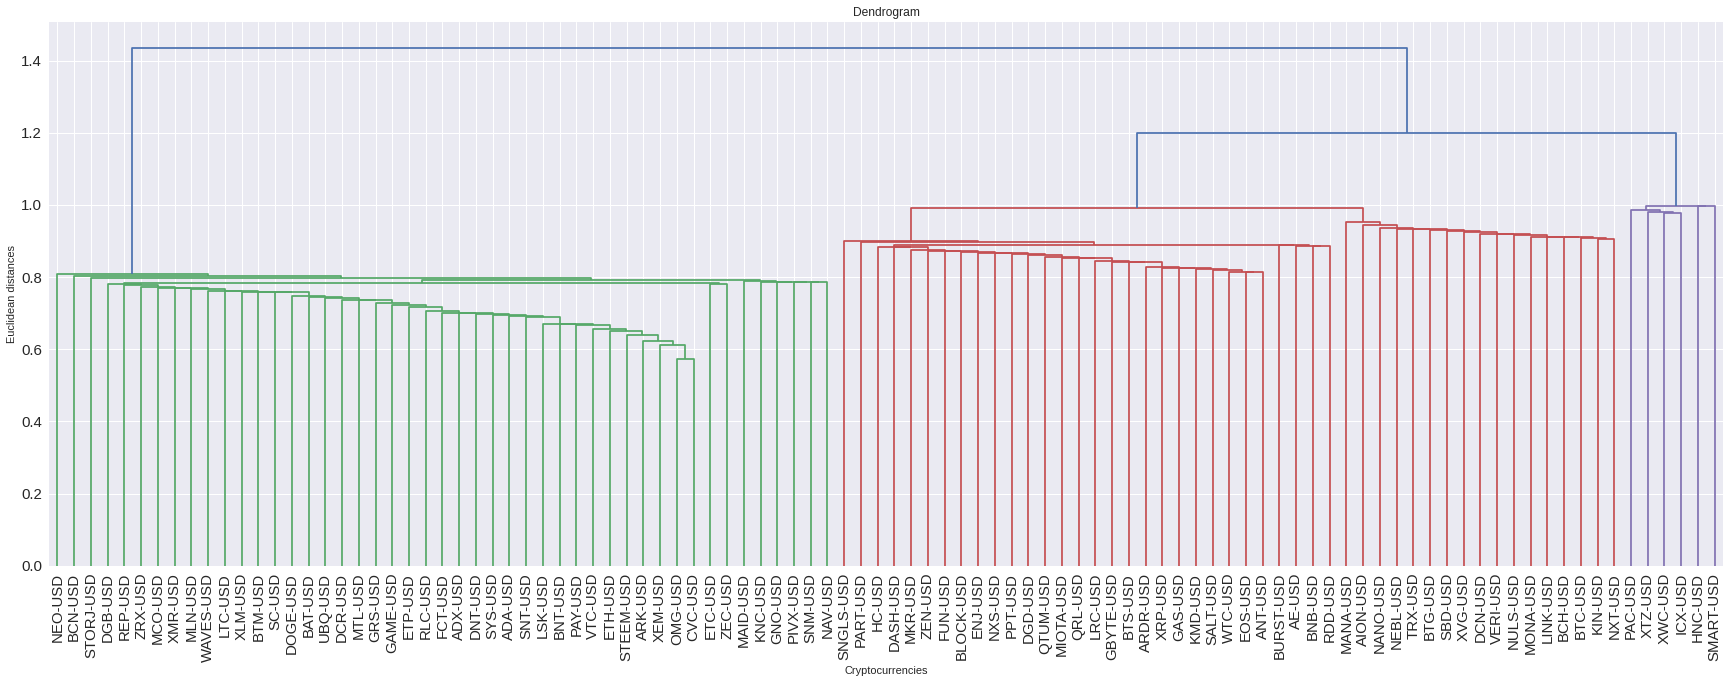

In [105]:
tickers_new = test_df.columns
ward_clustering(test_df, 30, tickers_new, dendo=1) 
